# Frontal Detection Analysis (Total Precip)

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import xesmf as xe
import nc_time_axis
import cftime 
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
from scipy import stats

In [2]:
# Import dask
import dask

# Use dask jobqueue
from dask_jobqueue import PBSCluster

# Import a client
from dask.distributed import Client

# Setup your PBSCluster
cluster = PBSCluster(
    cores=1, # The number of cores you want
    memory='20GB', # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='/glade/scratch/kdagon/dask-local', # Use your dask-local directory
    resource_spec='select=1:ncpus=1:mem=20GB', # Specify resources
    project='P06010014', # Input your project ID here
    walltime='03:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up -- how to determine this number?
# Here asking for 10 or 20 nodes (10 or 20 dask workers)
cluster.scale(20)

# Adaptive scaling option!
#cluster.adapt(minimum=1, maximum=100, wait_count=60)

# Change your url to the dask dashboard so you can see it
dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'})

# Setup your client
client = Client(cluster)

/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44907 instead
  warnings.warn(


In [3]:
client

<Client: 'tcp://10.12.206.51:43911' processes=0 threads=0, memory=0 B>

## Read and process fronts given input file
All fronts and fronts by type

In [4]:
def process_fronts(path, file):
    fronts_ds = xr.open_dataset(path+file, chunks={'time':360})
    
    # convert longitudes to match CESM data (conservative regridding only)
    #fronts_ds_lons = fronts_ds.assign_coords(lon=(fronts_ds.lon % 360), keep_attrs=True)
    #fronts_ds_lons.lon.attrs = fronts_ds.lon.attrs
    #fronts = fronts_ds_lons.fronts
    
    fronts = fronts_ds.fronts
    #print(fronts.front_type.values)
    
    # subset for a 15-year climatology (if applicable)
    if fronts.shape[0] > 43800:
        fronts = fronts[:43800]

    # all fronts
    allfronts = fronts.argmax(dim='front')
    anyfront = allfronts.where(allfronts < 4) # masking out no front areas
    
    # cold fronts
    allcoldfronts = fronts.sel(front=0) # see fronts.front_type.values for indices
    anycoldfront = allcoldfronts.where(allcoldfronts == 1) # masking out no cold front areas
    
    # warm fronts
    allwarmfronts = fronts.sel(front=1)
    anywarmfront = allwarmfronts.where(allwarmfronts == 1)
    
    # stationary fronts
    allstatfronts = fronts.sel(front=2)
    anystatfront = allstatfronts.where(allstatfronts == 1)
    
    # occluded fronts
    alloccfronts = fronts.sel(front=3)
    anyoccfront = alloccfronts.where(alloccfronts == 1)
    
    anyfront_types = xr.concat([anycoldfront, anywarmfront, anystatfront, anyoccfront], dim='front_type')
    
    return(anyfront, anyfront_types)

In [5]:
cesm_fronts_filepath = "/glade/work/kdagon/FrontDetector/CESMOutputs/"
fronts_file = "cesm_fronts_2000-2015_MaskedNetCDF_customgrid.nc"
fronts, fronts_type = process_fronts(cesm_fronts_filepath, fronts_file)

In [6]:
fronts_file_rcp = "cesm_fronts_2086-2100_MaskedNetCDF_customgrid.nc"
fronts_rcp, fronts_type_rcp = process_fronts(cesm_fronts_filepath, fronts_file_rcp)

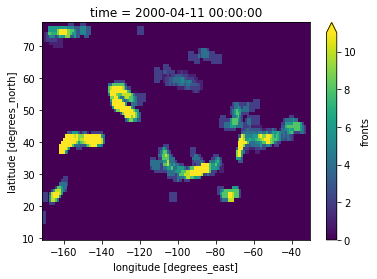

In [20]:
# test out resampling to daily frequency
# NOTE: this uses a lot of memory/resources as written
fronts.resample(time='D').sum(dim='time').isel(time=100).plot(robust=True)

In [7]:
# number of daily fronts at each gridpoint
fronts_day = fronts.notnull().resample(time='D').sum(dim='time')
fronts_day

<xarray.DataArray 'fronts' (time: 5476, lat: 68, lon: 141)>
dask.array<stack, shape=(5476, 68, 141), dtype=int64, chunksize=(1, 68, 141), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2000-01-01 00:00:00 ... 2015-01-01 00:00:00
  * lon      (lon) float64 -171.0 -170.0 -169.0 -168.0 ... -33.0 -32.0 -31.0
  * lat      (lat) float64 10.0 11.0 12.0 13.0 14.0 ... 73.0 74.0 75.0 76.0 77.0

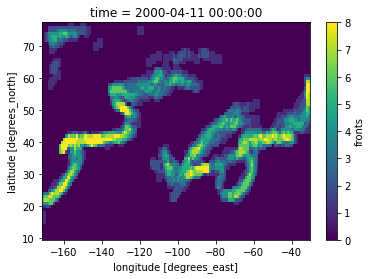

In [18]:
fronts_day.isel(time=100).plot()

### Read landfrac to subset land points (optional)

In [7]:
postprocessing_filepath = '/glade/campaign/cgd/ccr/kdagon/dlfront/postprocessing/'
landfrac_file = 'landfrac_1deg_bil.nc'

In [8]:
landfrac = xr.open_dataarray(postprocessing_filepath+landfrac_file)

## Read and process precipitation given input file

In [7]:
#def process_PRECT(path, file, landfrac):
def process_PRECT(path, file):
    PRECT_1deg = xr.open_dataarray(path+file, chunks={'time':600, 'lat':10, 'lon':20})
    
    # subset for a 15-year climatology (if applicable)
    if PRECT_1deg.shape[0] > 43800:
        PRECT_1deg = PRECT_1deg[:43800]
    
    # subset for land only (optional; comment out to use whole domain)
    #PRECT_1deg = PRECT_1deg.where(landfrac > 0)
    
    # Daily total precipitation (note .resample is computationally expensive)
    #PRECT_day = PRECT_1deg.resample(time='D').sum(dim='time')
    
    return(PRECT_1deg)

In [8]:
postprocessing_filepath = '/glade/campaign/cgd/ccr/kdagon/dlfront/postprocessing/'
PRECT_file = 'PRECT_3hravg_NA_hist_rcp26_1deg_bil.nc' # bilinear interpolation, units are m/s
#PRECT_file = 'PRECT_3hravg_NA_hist_rcp26_1deg_cons.nc' # conservative regridding
#PRECT = process_PRECT(postprocessing_filepath, PRECT_file, landfrac)
PRECT = process_PRECT(postprocessing_filepath, PRECT_file)

PRECT_file_rcp = 'PRECT_3hravg_NA_rcp85_1deg_bil.nc'
#PRECT_rcp = process_PRECT(postprocessing_filepath, PRECT_file_rcp, landfrac)
PRECT_rcp = process_PRECT(postprocessing_filepath, PRECT_file_rcp)

## Calculate fraction of total precipitation associated with a front

In [9]:
def calc_prect_front(PRECT, fronts, fronts_type):

    # precipitation overlapping with front
    PRECT_front = PRECT.where(fronts.notnull()).sum(dim='time')
    PRECT_front_type = PRECT.where(fronts_type.notnull()).sum(dim='time')
    
    # total precipitation
    PRECT_sum = PRECT.sum(dim='time')
    
    # proportion of precip overlapping with front
    PRECT_front_frac = 100*(PRECT_front/PRECT_sum)
    PRECT_front_frac_type = 100*(PRECT_front_type/PRECT_sum)
    
    # seasonal breakdown
    PRECT_front_byseason = PRECT.where(fronts.notnull()).groupby("time.season").sum(dim='time')
    PRECT_front_type_byseason = PRECT.where(fronts_type.notnull()).groupby("time.season").sum(dim='time')

    PRECT_sum_byseason = PRECT.groupby("time.season").sum(dim='time')
    
    PRECT_front_frac_byseason = 100*(PRECT_front_byseason/PRECT_sum_byseason)
    PRECT_front_frac_type_byseason = 100*(PRECT_front_type_byseason/PRECT_sum_byseason)
    
    #return(PRECT_front_frac, PRECT_front_frac_type)
    return(PRECT_front_frac_byseason, PRECT_front_frac_type_byseason)

In [10]:
# return seasonal values for plots
PRECT_front_frac, PRECT_front_frac_type = calc_prect_front(PRECT, fronts, fronts_type)
PRECT_front_frac_rcp, PRECT_front_frac_type_rcp = calc_prect_front(PRECT_rcp, fronts_rcp, fronts_type_rcp)

### Read in quantiles for significance hatching

In [22]:
PRECT_frontfrac_quantiles = xr.open_dataarray(postprocessing_filepath+'PRECT_frontfrac_boot_diffs_byseason.nc')
PRECT_frontfrac_quantiles

<xarray.DataArray 'PRECT' (season: 4, quantile: 2, lat: 25, lon: 58)>
array([[[[-10.388023, ...,  -4.147819],
         ...,
         [ -2.968849, ...,  -3.419204]],

        [[  9.851587, ...,   4.065627],
         ...,
         [  2.853651, ...,   3.612662]]],


       ...,


       [[[-12.05991 , ...,  -3.033365],
         ...,
         [ -3.249611, ...,  -5.20846 ]],

        [[ 12.433214, ...,   3.21866 ],
         ...,
         [  3.403109, ...,   4.846533]]]])
Coordinates:
  * lon       (lon) float64 -125.0 -124.0 -123.0 -122.0 ... -70.0 -69.0 -68.0
  * lat       (lat) float64 26.0 27.0 28.0 29.0 30.0 ... 47.0 48.0 49.0 50.0
  * quantile  (quantile) float64 0.025 0.975
  * season    (season) object 'DJF' 'MAM' 'JJA' 'SON'

### Seasonal spatial plots

In [23]:
PRECT_front_frac_CONUS = PRECT_front_frac.sel(lat=slice(26,50), lon=slice(-125,-68)).persist()
print(PRECT_front_frac_CONUS.max().values)

59.61874784274714


In [24]:
PRECT_front_frac_CONUS_rcp = PRECT_front_frac_rcp.sel(lat=slice(26,50), lon=slice(-125,-68)).persist()
print(PRECT_front_frac_CONUS_rcp.max().values)

57.76067802073159


In [25]:
PRECT_front_frac_CONUS_diff = PRECT_front_frac_CONUS_rcp - PRECT_front_frac_CONUS
print(PRECT_front_frac_CONUS_diff.max().values)
print(PRECT_front_frac_CONUS_diff.min().values)

23.40335783651728
-27.699125146973167


/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1887: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)
/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1887: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)
/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-pac

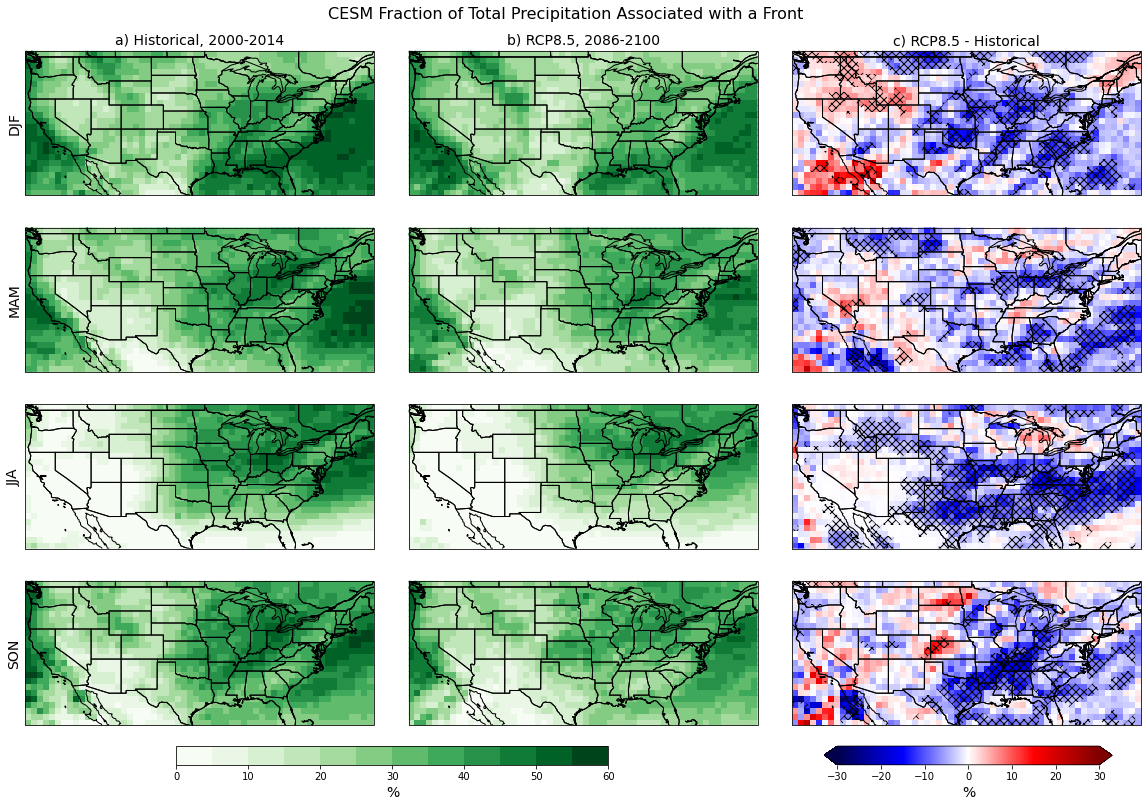

In [32]:
fig, axs = plt.subplots(4, 3, figsize=(20,13), subplot_kw={'projection': ccrs.PlateCarree()})

# discrete colormap for absolute plots
cmap=plt.cm.get_cmap('Greens', 12)
vmax = 60

# try changing the hatch color
plt.rcParams.update({'hatch.color': 'k'})

for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    if i == 0:
        axs[i,0].set_title('a) Historical, 2000-2014', fontsize=14) 
    field, lon = add_cyclic_point(PRECT_front_frac_CONUS.sel(season=season), coord=PRECT_front_frac_CONUS.lon)
    lat = PRECT_front_frac_CONUS.lat
    cf = axs[i,0].pcolor(lon, lat, field, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
    axs[i,0].coastlines(zorder=1)
    axs[i,0].add_feature(cfeature.BORDERS, zorder=2)
    axs[i,0].add_feature(cfeature.STATES, zorder=3)
    # add greyed out ocean
    #axs[i,0].add_feature(cfeature.OCEAN, zorder=4, facecolor='gainsboro', edgecolor='none')
    axs[i,0].set_ylabel(season, fontsize=14)
    axs[i,0].set_yticks([])

for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    if i == 0:
        axs[i,1].set_title('b) RCP8.5, 2086-2100', fontsize=14)
    field, lon = add_cyclic_point(PRECT_front_frac_CONUS_rcp.sel(season=season), coord=PRECT_front_frac_CONUS_rcp.lon)
    lat = PRECT_front_frac_CONUS_rcp.lat
    cf = axs[i,1].pcolor(lon, lat, field, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
    axs[i,1].coastlines(zorder=1)
    axs[i,1].add_feature(cfeature.BORDERS, zorder=2)
    axs[i,1].add_feature(cfeature.STATES, zorder=3)
    #axs[i,1].add_feature(cfeature.OCEAN, zorder=4, facecolor='gainsboro', edgecolor='none')
    
# add colorbar for absolute plots
cb1_ax = fig.add_axes([0.23, 0.1, 0.3, 0.02])
norm = mpl.colors.Normalize(vmin=0, vmax=vmax)
cb1 = mpl.colorbar.ColorbarBase(cb1_ax, cmap=cmap, norm=norm, orientation='horizontal')
#cb1 = mpl.colorbar.ColorbarBase(cb1_ax, cmap=cmap, norm=norm, orientation='horizontal', extend='max')
cb1.ax.set_xlabel('%', fontsize=14)

# colormap for diff plots
cmap2 = plt.cm.get_cmap('seismic')
vmin2=-30
vmax2=30

for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    if i == 0:
        axs[i,2].set_title('c) RCP8.5 - Historical', fontsize=14)
    # significance hatching - need to do this first or plots get cut off
    lon = PRECT_front_frac_CONUS_diff.lon # need to use original lon (add_cyclic_point adds to the lon dimension)
    lat = PRECT_front_frac_CONUS_diff.lat
    axs[i,2].contourf(lon, lat, xr.where((
        PRECT_front_frac_CONUS_diff.sel(season=season) <= PRECT_frontfrac_quantiles.sel(season=season, quantile=0.025)) | (
        PRECT_front_frac_CONUS_diff.sel(season=season) >= PRECT_frontfrac_quantiles.sel(season=season, quantile=0.975)),
        1.0, np.nan).data, 
        transform=ccrs.PlateCarree(),
        colors='none', levels=[1.0, 1.5],
        #hatches=['////'], #another hatch option
        hatches=['XXX'],
        zorder=10)
    field, lon = add_cyclic_point(PRECT_front_frac_CONUS_diff.sel(season=season), coord=PRECT_front_frac_CONUS_diff.lon)
    lat = PRECT_front_frac_CONUS_diff.lat
    cf = axs[i,2].pcolor(lon, lat, field, cmap=cmap2, vmin=vmin2, vmax=vmax2, transform=ccrs.PlateCarree())
    axs[i,2].coastlines(zorder=1)
    axs[i,2].add_feature(cfeature.BORDERS, zorder=2)
    axs[i,2].add_feature(cfeature.STATES, zorder=3)
    #axs[i,2].add_feature(cfeature.OCEAN, zorder=4, facecolor='gainsboro', edgecolor='none')

# colorbar for diff plots
cb2_ax = fig.add_axes([0.68, 0.1, 0.2, 0.02])
norm2 = mpl.colors.Normalize(vmin=vmin2, vmax=vmax2)
cb2 = mpl.colorbar.ColorbarBase(cb2_ax, cmap=cmap2, norm=norm2, orientation='horizontal', extend='both')
cb2.ax.set_xlabel('%', fontsize=14)    
    
# add title
fig.suptitle('CESM Fraction of Total Precipitation Associated with a Front', fontsize=16, y=0.91)

plt.subplots_adjust(wspace=0.1, hspace=0)

#plt.savefig('../figures/toSCP/PRECT_frontfrac_hist_rcp_diff_CONUS.png', bbox_inches='tight', dpi=300)
#plt.savefig('../figures/toSCP/PRECT_frontfrac_hist_rcp_diff_CONUS_sig.png', bbox_inches='tight', dpi=300)

### By front type - update with occ fronts when done

In [49]:
# quantiles
PRECT_frontfrac_cold_quantiles = xr.open_dataarray(postprocessing_filepath+'PRECT_frontfrac_cold_boot_diffs_byseason.nc')
PRECT_frontfrac_warm_quantiles = xr.open_dataarray(postprocessing_filepath+'PRECT_frontfrac_warm_boot_diffs_byseason.nc')
PRECT_frontfrac_stat_quantiles = xr.open_dataarray(postprocessing_filepath+'PRECT_frontfrac_stat_boot_diffs_byseason.nc')
PRECT_frontfrac_occ_quantiles = xr.open_dataarray(postprocessing_filepath+'PRECT_frontfrac_occ_boot_diffs_byseason.nc')

In [50]:
PRECT_frontfrac_quantiles_type = xr.concat([PRECT_frontfrac_cold_quantiles, PRECT_frontfrac_warm_quantiles, PRECT_frontfrac_stat_quantiles, PRECT_frontfrac_occ_quantiles], dim="front_type")
PRECT_frontfrac_quantiles_type.coords["front_type"] = ['cold','warm','stationary','occluded']
PRECT_frontfrac_quantiles_type

<xarray.DataArray 'PRECT' (front_type: 4, season: 4, quantile: 2, lat: 25, lon: 58)>
array([[[[[-9.28008169e+00, -9.87845572e+00, -1.06089954e+01, ...,
           -3.46081033e+00, -3.34897479e+00, -3.62785034e+00],
          [-1.15701515e+01, -9.34730955e+00, -9.35143709e+00, ...,
           -4.29542788e+00, -3.79202591e+00, -4.00382468e+00],
          [-9.46338223e+00, -9.56854899e+00, -1.00376844e+01, ...,
           -4.98317544e+00, -4.49748424e+00, -4.28378278e+00],
          ...,
          [-1.91393343e+00, -1.90925918e+00, -1.42034510e+00, ...,
           -7.82441943e-01, -1.31240567e+00, -1.28929822e+00],
          [-1.35864558e+00, -1.10978797e+00, -1.17275580e+00, ...,
           -6.94092737e-01, -6.75581663e-01, -1.00089192e+00],
          [-1.46560543e+00, -1.23381925e+00, -1.09360374e+00, ...,
           -9.63415808e-01, -9.35839725e-01, -8.00396449e-01]],

         [[ 9.04919334e+00,  9.68168999e+00,  1.06675778e+01, ...,
            3.49860148e+00,  3.35129042e+00,  3.51562114e+00],
          [ 1.14842242e+01,  9.02214125e+00,  9.20645097e+00, ...,
            4.07214703e+00,  3.70647907e+00,  3.76833705e+00],
          [ 9.37217416e+00,  9.52840382e+00,  9.72008853e+00, ...,
            4.87966960e+00,  4.44239182e+00,  3.95240733e+00],
...
          [-1.43498671e+00, -1.25779954e+00, -1.12763894e+00, ...,
           -2.80967013e+00, -2.52879012e+00, -3.08185901e+00],
          [-1.62869017e+00, -1.56556174e+00, -9.90038520e-01, ...,
           -2.40799588e+00, -2.77227734e+00, -2.90770105e+00],
          [-1.93945957e+00, -1.41700593e+00, -1.25058817e+00, ...,
           -2.48656165e+00, -3.64266063e+00, -3.53676127e+00]],

         [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
            1.39264764e-02,  0.00000000e+00,  0.00000000e+00],
          [ 0.00000000e+00,  0.00000000e+00,  3.77927097e-02, ...,
            1.14014070e-02,  0.00000000e+00,  0.00000000e+00],
          ...,
          [ 1.41852143e+00,  1.25118576e+00,  1.18055524e+00, ...,
            2.86101279e+00,  2.66526837e+00,  2.89275362e+00],
          [ 1.52888999e+00,  1.59257078e+00,  9.70706979e-01, ...,
            2.54959680e+00,  2.62854544e+00,  2.86102031e+00],
          [ 1.78177287e+00,  1.39783993e+00,  1.23710069e+00, ...,
            2.55954804e+00,  3.47716756e+00,  3.50698983e+00]]]]])
Coordinates:
  * lon         (lon) float64 -125.0 -124.0 -123.0 -122.0 ... -70.0 -69.0 -68.0
  * lat         (lat) float64 26.0 27.0 28.0 29.0 30.0 ... 47.0 48.0 49.0 50.0
  * quantile    (quantile) float64 0.025 0.975
  * season      (season) object 'DJF' 'MAM' 'JJA' 'SON'
  * front_type  (front_type) <U10 'cold' 'warm' 'stationary' 'occluded'

In [14]:
PRECT_front_frac_type_CONUS = PRECT_front_frac_type.sel(lat=slice(26,50), lon=slice(-125,-68)).persist()
#print(PRECT_front_frac_type_CONUS.max().values)

In [15]:
# max values for each front type
print(PRECT_front_frac_type_CONUS.max(dim=('lat','lon','season')).values)

[45.85586896 29.61017597 44.96832976 24.2290487 ]


In [16]:
PRECT_front_frac_type_CONUS_rcp = PRECT_front_frac_type_rcp.sel(lat=slice(26,50), lon=slice(-125,-68)).persist()
#print(PRECT_front_frac_type_CONUS_rcp.max().values)
print(PRECT_front_frac_type_CONUS_rcp.max(dim=('lat','lon','season')).values)

[39.73466827 26.5786587  42.49868596 15.90995955]


In [17]:
PRECT_front_frac_type_CONUS_diff = PRECT_front_frac_type_CONUS_rcp - PRECT_front_frac_type_CONUS
print(PRECT_front_frac_type_CONUS_diff.max(dim=('lat','lon','season')).values)
print(PRECT_front_frac_type_CONUS_diff.min(dim=('lat','lon','season')).values)

[23.75781351 18.00331543 18.50448748 10.13240287]
[-25.67391738 -21.94505785 -30.87804255 -22.34160124]


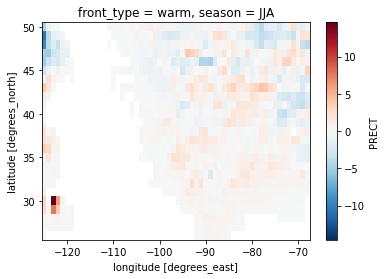

In [51]:
PRECT_front_frac_type_CONUS_diff.where(abs(PRECT_front_frac_type_CONUS_diff)>0.001).sel(season='JJA',front_type='warm').plot()

In [54]:
# try masking small diffs so small changes don't look overly significant
# how to determine this threshold? some percentage?
PRECT_front_frac_type_CONUS_diff_mask = PRECT_front_frac_type_CONUS_diff.where(abs(PRECT_front_frac_type_CONUS_diff)>0.0001)

/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1887: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)
/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1887: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)
/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-pac

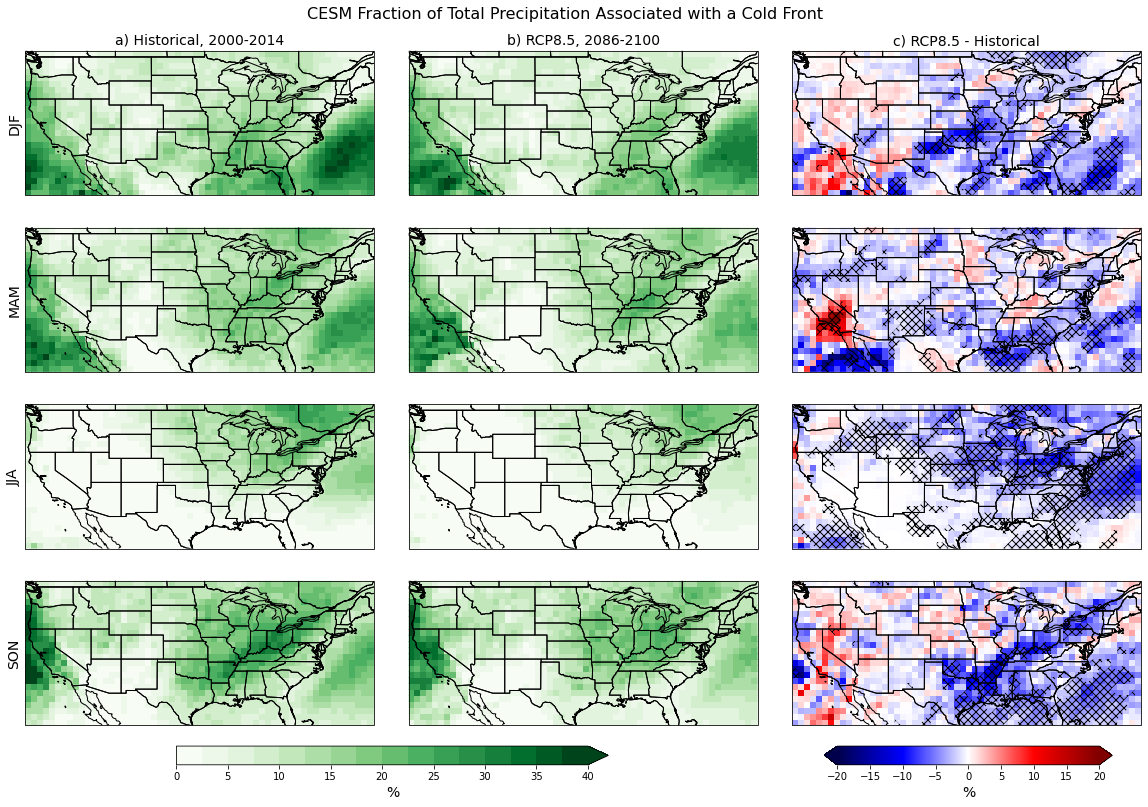

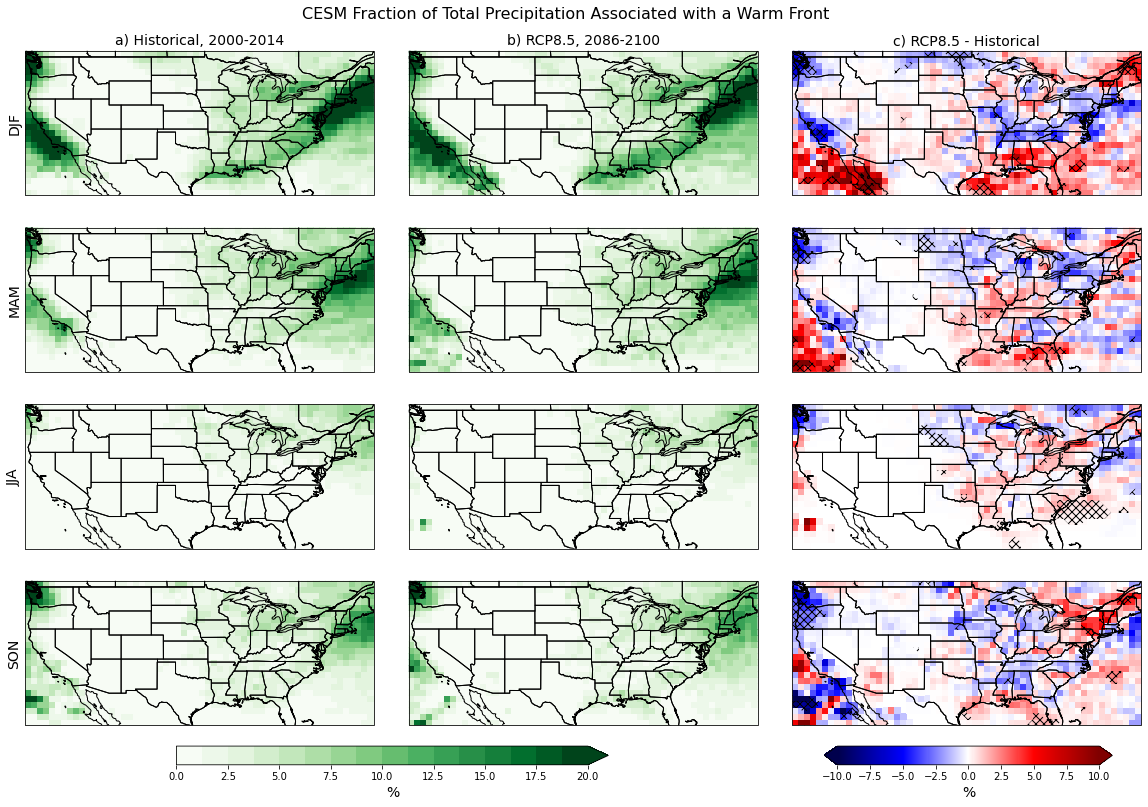

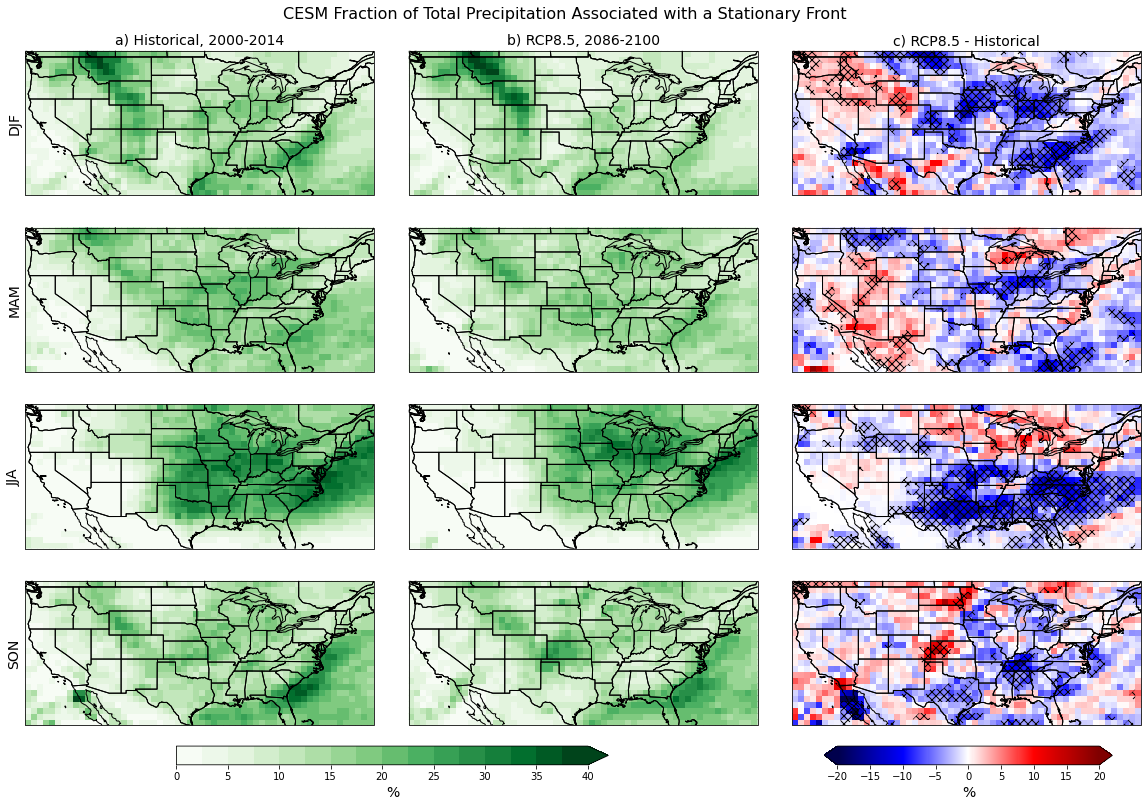

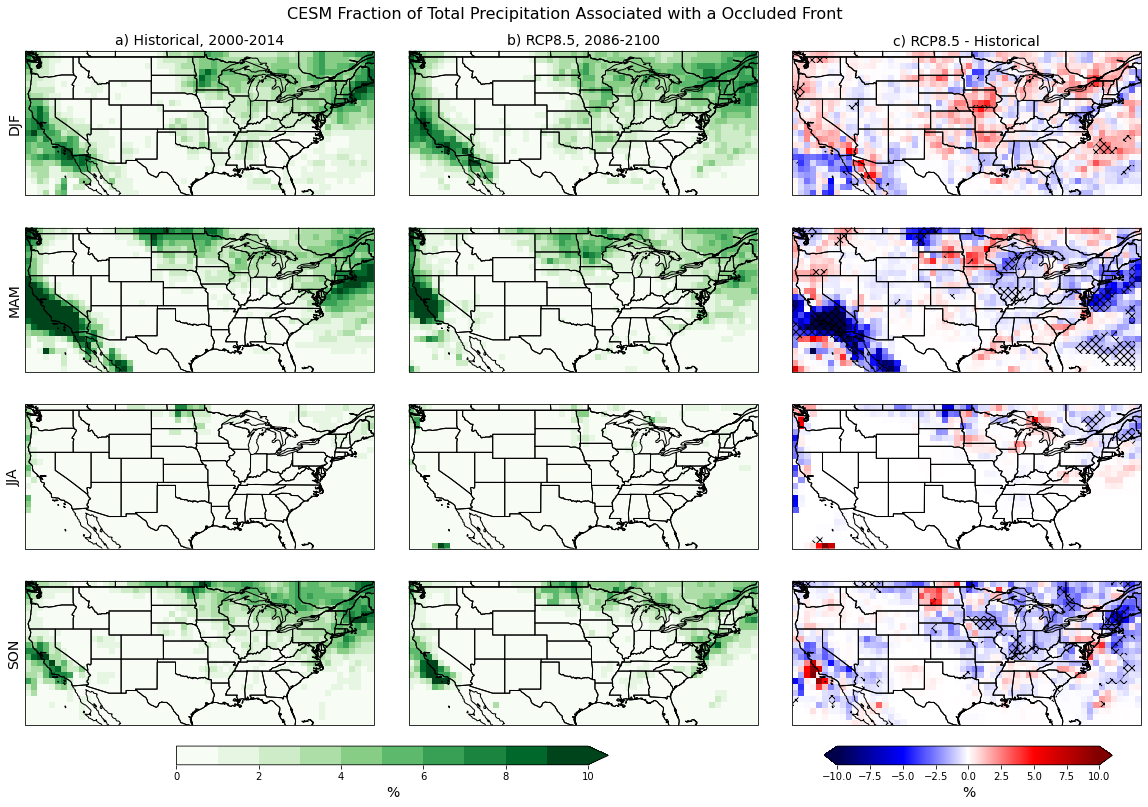

In [55]:
# loop over front type
frstrings = ('Cold', 'Warm', 'Stationary', 'Occluded') # for labels
ftypes = ('cold', 'warm', 'stationary', 'occluded') # lowercase for indexing
nfr = len(frstrings)

vmaxes = [40,20,40,10]
ncols = [16,16,16,10]
vdiffs = [20,10,20,10]

# then season
seastrings = ('DJF', 'MAM', 'JJA', 'SON')
nsea = len(seastrings)

for f in range(nfr):
    fig, axs = plt.subplots(4, 3, figsize=(20,13), subplot_kw={'projection': ccrs.PlateCarree()})

    # discrete colormap for absolute plots
    cmap=plt.cm.get_cmap('Greens', ncols[f])
    vmax = vmaxes[f]

    for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
        if i == 0:
            axs[i,0].set_title('a) Historical, 2000-2014', fontsize=14) 
        field, lon = add_cyclic_point(PRECT_front_frac_type_CONUS.sel(season=season, front_type=ftypes[f]), coord=PRECT_front_frac_type_CONUS.lon)
        lat = PRECT_front_frac_type_CONUS.lat
        cf = axs[i,0].pcolor(lon, lat, field, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
        axs[i,0].coastlines(zorder=1)
        axs[i,0].add_feature(cfeature.BORDERS, zorder=2)
        axs[i,0].add_feature(cfeature.STATES, zorder=3)
        axs[i,0].set_ylabel(season, fontsize=14)
        axs[i,0].set_yticks([])

    for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
        if i == 0:
            axs[i,1].set_title('b) RCP8.5, 2086-2100', fontsize=14)
        field, lon = add_cyclic_point(PRECT_front_frac_type_CONUS_rcp.sel(season=season, front_type=ftypes[f]), coord=PRECT_front_frac_type_CONUS_rcp.lon)
        lat = PRECT_front_frac_type_CONUS_rcp.lat
        cf = axs[i,1].pcolor(lon, lat, field, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
        axs[i,1].coastlines(zorder=1)
        axs[i,1].add_feature(cfeature.BORDERS, zorder=2)
        axs[i,1].add_feature(cfeature.STATES, zorder=3)
    
    # add colorbar for absolute plots
    cb1_ax = fig.add_axes([0.23, 0.1, 0.3, 0.02])
    norm = mpl.colors.Normalize(vmin=0, vmax=vmax)
    #cb1 = mpl.colorbar.ColorbarBase(cb1_ax, cmap=cmap, norm=norm, orientation='horizontal')
    cb1 = mpl.colorbar.ColorbarBase(cb1_ax, cmap=cmap, norm=norm, orientation='horizontal', extend='max')
    cb1.ax.set_xlabel('%', fontsize=14)

    # colormap for diff plots
    cmap2 = plt.cm.get_cmap('seismic')
    vmin2=-vdiffs[f]
    vmax2=vdiffs[f]

    for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
        if i == 0:
            axs[i,2].set_title('c) RCP8.5 - Historical', fontsize=14)
        # significance hatching - need to do this first or plots get cut off
        lon = PRECT_front_frac_type_CONUS_diff_mask.lon # need to use original lon (add_cyclic_point adds to the lon dimension)
        lat = PRECT_front_frac_type_CONUS_diff_mask.lat
        axs[i,2].contourf(lon, lat, xr.where((
            PRECT_front_frac_type_CONUS_diff_mask.sel(season=season, front_type=ftypes[f]) <= PRECT_frontfrac_quantiles_type.sel(season=season, front_type=ftypes[f], quantile=0.025)) | (
            PRECT_front_frac_type_CONUS_diff_mask.sel(season=season, front_type=ftypes[f]) >= PRECT_frontfrac_quantiles_type.sel(season=season, front_type=ftypes[f], quantile=0.975)),
            1.0, np.nan).data, 
            transform=ccrs.PlateCarree(),
            colors='none', levels=[1.0, 1.5],
            #hatches=['////'], #another hatch option
            hatches=['XXX'],
            zorder=10)
        field, lon = add_cyclic_point(PRECT_front_frac_type_CONUS_diff_mask.sel(season=season, front_type=ftypes[f]), coord=PRECT_front_frac_type_CONUS_diff_mask.lon)
        lat = PRECT_front_frac_type_CONUS_diff_mask.lat
        cf = axs[i,2].pcolor(lon, lat, field, cmap=cmap2, vmin=vmin2, vmax=vmax2, transform=ccrs.PlateCarree())
        axs[i,2].coastlines(zorder=1)
        axs[i,2].add_feature(cfeature.BORDERS, zorder=2)
        axs[i,2].add_feature(cfeature.STATES, zorder=3)

    # colorbar for diff plots
    cb2_ax = fig.add_axes([0.68, 0.1, 0.2, 0.02])
    norm2 = mpl.colors.Normalize(vmin=vmin2, vmax=vmax2)
    cb2 = mpl.colorbar.ColorbarBase(cb2_ax, cmap=cmap2, norm=norm2, orientation='horizontal', extend='both')
    cb2.ax.set_xlabel('%', fontsize=14)    
    
    # add title
    fig.suptitle('CESM Fraction of Total Precipitation Associated with a '+frstrings[f]+' Front', fontsize=16, y=0.91)
    plt.subplots_adjust(wspace=0.1, hspace=0)

    plt.savefig('../figures/toSCP/PRECT_frontfrac_hist_rcp_diff_'+ftypes[f]+'_fronts_CONUS_sig.png', bbox_inches='tight', dpi=300)

## Calculate mean precipitation intensity associated with a front

In [22]:
def calc_prect_front_int(PRECT, fronts, fronts_type):

    # mean precipitation intensity overlapping with front
    PRECT_front_int = PRECT.where(fronts.notnull()).mean(dim='time')
    PRECT_front_int_type = PRECT.where(fronts_type.notnull()).mean(dim='time')
    
    # mean precip intensity
    PREC_int = PRECT.mean(dim='time')
    
    # seasonal breakdown
    PRECT_front_int_byseason = PRECT.where(fronts.notnull()).groupby("time.season").mean(dim='time')
    PRECT_front_int_type_byseason = PRECT.where(fronts_type.notnull()).groupby("time.season").mean(dim='time')

    PRECT_int_byseason = PRECT.groupby("time.season").mean(dim='time')
    
    return(PRECT_front_int_byseason, PRECT_front_int_type_byseason)

In [23]:
# return seasonal values for plots
PRECT_front_int, PRECT_front_int_type = calc_prect_front_int(PRECT, fronts, fronts_type)
PRECT_front_int_rcp, PRECT_front_int_type_rcp = calc_prect_front_int(PRECT_rcp, fronts_rcp, fronts_type_rcp)

In [24]:
Punits = 60*60*24*1000 # convert m/s to mm/day

In [25]:
PRECT_front_int_CONUS = PRECT_front_int.sel(lat=slice(26,50), lon=slice(-125,-68)).persist()
print(PRECT_front_int_CONUS.max().values*Punits)

43.75461819568395


In [26]:
PRECT_front_int_type_CONUS = PRECT_front_int_type.sel(lat=slice(26,50), lon=slice(-125,-68)).persist()

In [27]:
PRECT_front_int_CONUS_rcp = PRECT_front_int_rcp.sel(lat=slice(26,50), lon=slice(-125,-68)).persist()
print(PRECT_front_int_CONUS_rcp.max().values*Punits)

48.15046217985002


In [28]:
PRECT_front_int_type_CONUS_rcp = PRECT_front_int_type_rcp.sel(lat=slice(26,50), lon=slice(-125,-68)).persist()

In [29]:
PRECT_front_int_CONUS_diff = PRECT_front_int_CONUS_rcp - PRECT_front_int_CONUS
print(PRECT_front_int_CONUS_diff.max().values*Punits)
print(PRECT_front_int_CONUS_diff.min().values*Punits)

11.496106832485937
-8.496687985315514


In [30]:
PRECT_front_int_type_CONUS_diff = PRECT_front_int_type_CONUS_rcp - PRECT_front_int_type_CONUS

/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1887: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)
/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1887: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)
/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-pac

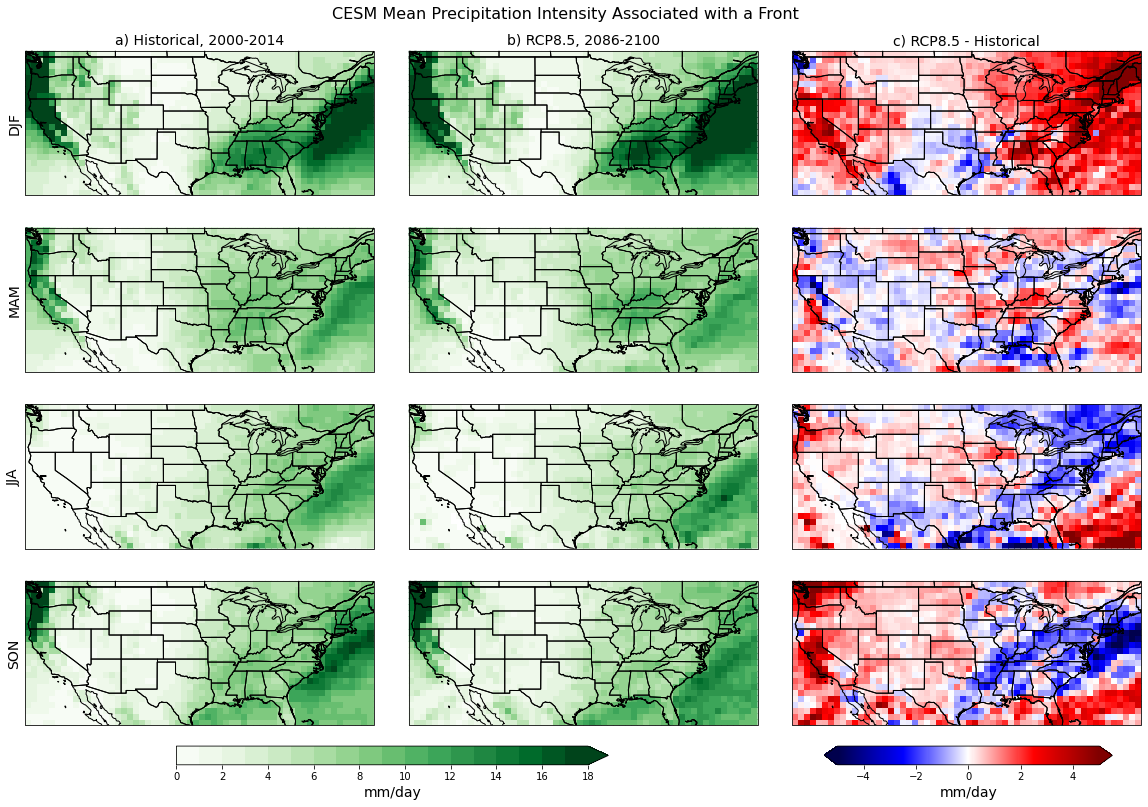

In [95]:
fig, axs = plt.subplots(4, 3, figsize=(20,13), subplot_kw={'projection': ccrs.PlateCarree()})

# discrete colormap for absolute plots
cmap=plt.cm.get_cmap('Greens', 18)
vmax = 18

for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    if i == 0:
        axs[i,0].set_title('a) Historical, 2000-2014', fontsize=14) 
    field, lon = add_cyclic_point(PRECT_front_int_CONUS.sel(season=season)*Punits, coord=PRECT_front_int_CONUS.lon)
    lat = PRECT_front_int_CONUS.lat
    cf = axs[i,0].pcolor(lon, lat, field, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
    axs[i,0].coastlines(zorder=1)
    axs[i,0].add_feature(cfeature.BORDERS, zorder=2)
    axs[i,0].add_feature(cfeature.STATES, zorder=3)
    # add greyed out ocean
    #axs[i,0].add_feature(cfeature.OCEAN, zorder=4, facecolor='gainsboro', edgecolor='none')
    axs[i,0].set_ylabel(season, fontsize=14)
    axs[i,0].set_yticks([])

for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    if i == 0:
        axs[i,1].set_title('b) RCP8.5, 2086-2100', fontsize=14)
    field, lon = add_cyclic_point(PRECT_front_int_CONUS_rcp.sel(season=season)*Punits, coord=PRECT_front_int_CONUS_rcp.lon)
    lat = PRECT_front_int_CONUS_rcp.lat
    cf = axs[i,1].pcolor(lon, lat, field, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
    axs[i,1].coastlines(zorder=1)
    axs[i,1].add_feature(cfeature.BORDERS, zorder=2)
    axs[i,1].add_feature(cfeature.STATES, zorder=3)
    #axs[i,1].add_feature(cfeature.OCEAN, zorder=4, facecolor='gainsboro', edgecolor='none')
    
# add colorbar for absolute plots
cb1_ax = fig.add_axes([0.23, 0.1, 0.3, 0.02])
norm = mpl.colors.Normalize(vmin=0, vmax=vmax)
#cb1 = mpl.colorbar.ColorbarBase(cb1_ax, cmap=cmap, norm=norm, orientation='horizontal')
cb1 = mpl.colorbar.ColorbarBase(cb1_ax, cmap=cmap, norm=norm, orientation='horizontal', extend='max')
cb1.ax.set_xlabel('mm/day', fontsize=14)

# colormap for diff plots
cmap2 = plt.cm.get_cmap('seismic')
vmin2=-5
vmax2=5

for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    if i == 0:
        axs[i,2].set_title('c) RCP8.5 - Historical', fontsize=14)
    field, lon = add_cyclic_point(PRECT_front_int_CONUS_diff.sel(season=season)*Punits, coord=PRECT_front_int_CONUS_diff.lon)
    lat = PRECT_front_int_CONUS_diff.lat
    cf = axs[i,2].pcolor(lon, lat, field, cmap=cmap2, vmin=vmin2, vmax=vmax2, transform=ccrs.PlateCarree())
    axs[i,2].coastlines(zorder=1)
    axs[i,2].add_feature(cfeature.BORDERS, zorder=2)
    axs[i,2].add_feature(cfeature.STATES, zorder=3)
    #axs[i,2].add_feature(cfeature.OCEAN, zorder=4, facecolor='gainsboro', edgecolor='none')

# colorbar for diff plots
cb2_ax = fig.add_axes([0.68, 0.1, 0.2, 0.02])
norm2 = mpl.colors.Normalize(vmin=vmin2, vmax=vmax2)
cb2 = mpl.colorbar.ColorbarBase(cb2_ax, cmap=cmap2, norm=norm2, orientation='horizontal', extend='both')
cb2.ax.set_xlabel('mm/day', fontsize=14)    
    
# add title

fig.suptitle('CESM Mean Precipitation Intensity Associated with a Front', fontsize=16, y=0.91)

plt.subplots_adjust(wspace=0.1, hspace=0)

#plt.savefig('../figures/toSCP/PRECT_frontint_hist_rcp_diff_CONUS.png', bbox_inches='tight', dpi=300)

## Calculate front frequency

In [31]:
def calc_front_freq(fronts, fronts_type):
    
    # number of timesteps with fronts relative to total timesteps
    front_freq = 100*(fronts.notnull().sum(dim='time')/len(fronts.time))
    front_freq_type = 100*(fronts_type.notnull().sum(dim='time')/len(fronts.time))
    
    # number of timesteps with fronts per season relative to timesteps in each season
    front_freq_byseason = 100*(fronts.notnull().groupby('time.season').sum(dim='time')/fronts.time.groupby('time.season').count())
    front_freq_type_byseason = 100*(fronts_type.notnull().groupby('time.season').sum(dim='time')/fronts.time.groupby('time.season').count())
    
    # return seasonal values
    return(front_freq_byseason, front_freq_type_byseason)

In [32]:
# return seasonal values for plots
front_freq, front_freq_type = calc_front_freq(fronts, fronts_type)
front_freq_rcp, front_freq_type_rcp = calc_front_freq(fronts_rcp, fronts_type_rcp)

In [33]:
front_freq_CONUS = front_freq.sel(lat=slice(26,50), lon=slice(-125,-68)).persist()
print(front_freq_CONUS.max().values)

29.882246376811594


In [34]:
front_freq_type_CONUS = front_freq_type.sel(lat=slice(26,50), lon=slice(-125,-68)).persist()

In [35]:
front_freq_CONUS_rcp = front_freq_rcp.sel(lat=slice(26,50), lon=slice(-125,-68)).persist()
print(front_freq_CONUS_rcp.max().values)

30.407608695652172


In [36]:
front_freq_type_CONUS_rcp = front_freq_type_rcp.sel(lat=slice(26,50), lon=slice(-125,-68)).persist()

In [37]:
front_freq_CONUS_diff = front_freq_CONUS_rcp - front_freq_CONUS
print(front_freq_CONUS_diff.max().values)
print(front_freq_CONUS_diff.min().values)

7.599637681159418
-11.222826086956523


In [38]:
front_freq_type_CONUS_diff = front_freq_type_CONUS_rcp - front_freq_type_CONUS

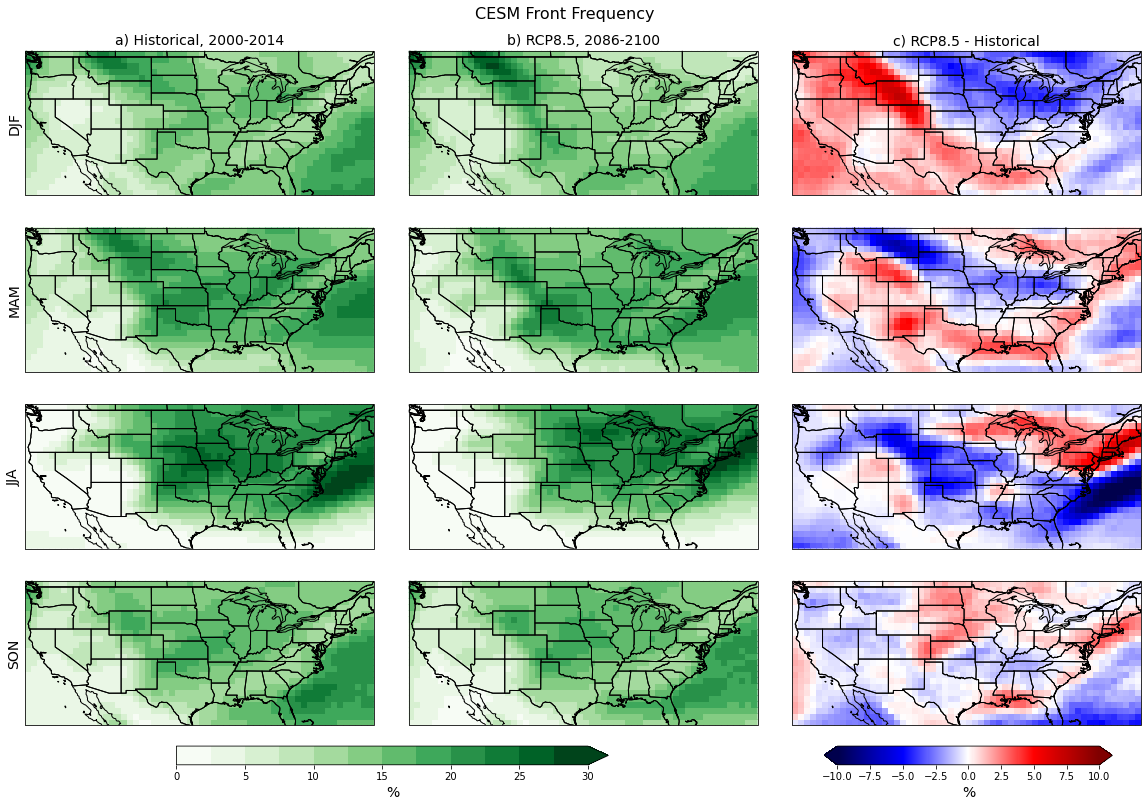

In [97]:
fig, axs = plt.subplots(4, 3, figsize=(20,13), subplot_kw={'projection': ccrs.PlateCarree()})

# discrete colormap for absolute plots
cmap=plt.cm.get_cmap('Greens', 12)
vmax = 30

for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    if i == 0:
        axs[i,0].set_title('a) Historical, 2000-2014', fontsize=14) 
    field, lon = add_cyclic_point(front_freq_CONUS.sel(season=season), coord=front_freq_CONUS.lon)
    lat = front_freq_CONUS.lat
    cf = axs[i,0].pcolor(lon, lat, field, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
    axs[i,0].coastlines(zorder=1)
    axs[i,0].add_feature(cfeature.BORDERS, zorder=2)
    axs[i,0].add_feature(cfeature.STATES, zorder=3)
    # add greyed out ocean
    #axs[i,0].add_feature(cfeature.OCEAN, zorder=4, facecolor='gainsboro', edgecolor='none')
    axs[i,0].set_ylabel(season, fontsize=14)
    axs[i,0].set_yticks([])

for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    if i == 0:
        axs[i,1].set_title('b) RCP8.5, 2086-2100', fontsize=14)
    field, lon = add_cyclic_point(front_freq_CONUS_rcp.sel(season=season), coord=front_freq_CONUS_rcp.lon)
    lat = front_freq_CONUS_rcp.lat
    cf = axs[i,1].pcolor(lon, lat, field, cmap=cmap, vmin=0, vmax=vmax, transform=ccrs.PlateCarree())
    axs[i,1].coastlines(zorder=1)
    axs[i,1].add_feature(cfeature.BORDERS, zorder=2)
    axs[i,1].add_feature(cfeature.STATES, zorder=3)
    #axs[i,1].add_feature(cfeature.OCEAN, zorder=4, facecolor='gainsboro', edgecolor='none')
    
# add colorbar for absolute plots
cb1_ax = fig.add_axes([0.23, 0.1, 0.3, 0.02])
norm = mpl.colors.Normalize(vmin=0, vmax=vmax)
#cb1 = mpl.colorbar.ColorbarBase(cb1_ax, cmap=cmap, norm=norm, orientation='horizontal')
cb1 = mpl.colorbar.ColorbarBase(cb1_ax, cmap=cmap, norm=norm, orientation='horizontal', extend='max')
cb1.ax.set_xlabel('%', fontsize=14)

# colormap for diff plots
cmap2 = plt.cm.get_cmap('seismic')
vmin2=-10
vmax2=10

for i, season in enumerate(('DJF', 'MAM', 'JJA', 'SON')):
    if i == 0:
        axs[i,2].set_title('c) RCP8.5 - Historical', fontsize=14)
    field, lon = add_cyclic_point(front_freq_CONUS_diff.sel(season=season), coord=front_freq_CONUS_diff.lon)
    lat = front_freq_CONUS_diff.lat
    cf = axs[i,2].pcolor(lon, lat, field, cmap=cmap2, vmin=vmin2, vmax=vmax2, transform=ccrs.PlateCarree())
    axs[i,2].coastlines(zorder=1)
    axs[i,2].add_feature(cfeature.BORDERS, zorder=2)
    axs[i,2].add_feature(cfeature.STATES, zorder=3)
    #axs[i,2].add_feature(cfeature.OCEAN, zorder=4, facecolor='gainsboro', edgecolor='none')

# colorbar for diff plots
cb2_ax = fig.add_axes([0.68, 0.1, 0.2, 0.02])
norm2 = mpl.colors.Normalize(vmin=vmin2, vmax=vmax2)
cb2 = mpl.colorbar.ColorbarBase(cb2_ax, cmap=cmap2, norm=norm2, orientation='horizontal', extend='both')
cb2.ax.set_xlabel('%', fontsize=14)    
    
# add title
fig.suptitle('CESM Front Frequency', fontsize=16, y=0.91)

plt.subplots_adjust(wspace=0.1, hspace=0)

#plt.savefig('../figures/toSCP/front_freq_hist_rcp_diff_CONUS.png', bbox_inches='tight', dpi=300)

## Calculate changes in frequency and intensity
Following Utsumi et al. (2016)

In [39]:
def calc_freq_int(front_freq, front_freq_diff, PRECT_front_int, PRECT_front_int_diff):
    
    # PRECT unit conversion m/s to mm/day
    Punits = 60*60*24*1000
    
    # change due to the frequency change, change in front frequency * mean precip intensity per event (mm/day) historical climate
    # "frequency term" in mm/day
    freq_term = (front_freq_diff/100) * (PRECT_front_int*Punits)
    
    # change due to the intensity change, front frequency historical climate * change in mean precip intensity per event (mm/day)
    # "intensity term" in mm/day
    int_term = (front_freq/100) * (PRECT_front_int_diff*Punits)
    
    # covariation term, change in front frequency * change in mean precip intensity per event (mm/day)
    cov_term = (front_freq_diff/100) * PRECT_front_int_diff*Punits
    
    # change in the total precipitation for fronts, mm/day
    delta_P = freq_term + int_term + cov_term
    
    return(freq_term, int_term, cov_term, delta_P)

In [40]:
freq_term, int_term, cov_term, delta_P = calc_freq_int(front_freq_CONUS, front_freq_CONUS_diff, PRECT_front_int_CONUS, PRECT_front_int_CONUS_diff)

In [99]:
print(freq_term.max().values, freq_term.min().values)

1.0463148844500196 -1.4923403783893088


In [100]:
print(int_term.max().values, int_term.min().values)

1.3870432960078738 -1.1227999830755409


In [101]:
print(cov_term.max().values, cov_term.min().values)

0.1383790637243677 -0.6327491324572003


In [102]:
print(delta_P.max().values, delta_P.min().values)

1.0982841541618225 -1.5013994107090138


/glade/scratch/kdagon/ipykernel_120635/1383559011.py:49: MatplotlibDeprecationWarning: Passing the cmap parameter of __init__() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  cb2 = mpl.colorbar.ColorbarBase(cb2_ax, cmap, norm=norm2, orientation='horizontal', extend='both')


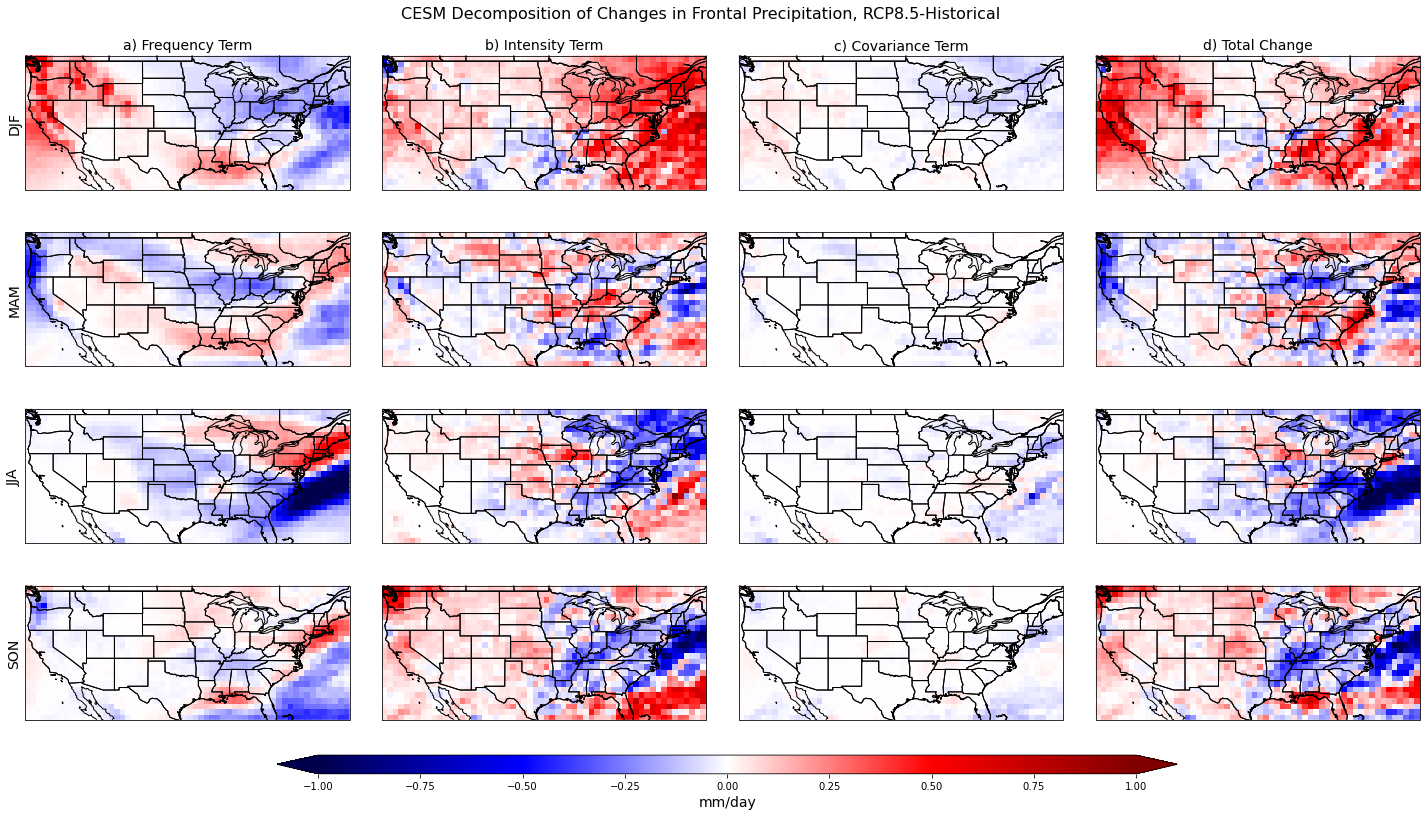

In [105]:
# spatial plots by season
seastrings = ('DJF', 'MAM', 'JJA', 'SON')
nsea = len(seastrings)
fig, axs = plt.subplots(nsea, 4, figsize=(25,13), subplot_kw={'projection': ccrs.PlateCarree()})

cmap = plt.cm.get_cmap('seismic')

# Frequency term
vmin1=-1
vmax1=1

for i, season in enumerate(seastrings):
    if i==0:
        axs[i,0].set_title('a) Frequency Term', fontsize=14)
    field, lon = add_cyclic_point(freq_term.sel(season=season), coord=freq_term.lon)
    lat = freq_term.lat
    cf = axs[i,0].pcolor(lon, lat, field, cmap=cmap, vmin=vmin1, vmax=vmax1, transform=ccrs.PlateCarree())
    axs[i,0].coastlines(zorder=1)
    axs[i,0].add_feature(cfeature.BORDERS, zorder=2)
    axs[i,0].add_feature(cfeature.STATES, zorder=3)
    #axs[i,0].add_feature(cfeature.OCEAN, zorder=4, facecolor='gainsboro', edgecolor='none')
    axs[i,0].set_ylabel(season, fontsize=14)
    axs[i,0].set_yticks([])

# First colorbar
#cb1_ax = fig.add_axes([0.145, 0.08, 0.2, 0.02])
#norm1 = mpl.colors.Normalize(vmin=vmin1, vmax=vmax1)
#cb1 = mpl.colorbar.ColorbarBase(cb1_ax, cmap, norm=norm1, orientation='horizontal', extend='both')
#cb1.ax.set_xlabel('mm/day', fontsize=14)

# Intensity term
vmin2=-1
vmax2=1

for i, season in enumerate(seastrings):
    if i==0:
        axs[i,1].set_title('b) Intensity Term', fontsize=14)
    field, lon = add_cyclic_point(int_term.sel(season=season), coord=int_term.lon)
    lat = int_term.lat
    cf = axs[i,1].pcolor(lon, lat, field, cmap=cmap, vmin=vmin2, vmax=vmax2, transform=ccrs.PlateCarree())
    axs[i,1].coastlines(zorder=1)
    axs[i,1].add_feature(cfeature.BORDERS, zorder=2)
    axs[i,1].add_feature(cfeature.STATES, zorder=3)
    #axs[i,1].add_feature(cfeature.OCEAN, zorder=4, facecolor='gainsboro', edgecolor='none')

# Second colorbar
cb2_ax = fig.add_axes([0.265, 0.09, 0.5, 0.02])
norm2 = mpl.colors.Normalize(vmin=vmin2, vmax=vmax2)
cb2 = mpl.colorbar.ColorbarBase(cb2_ax, cmap, norm=norm2, orientation='horizontal', extend='both')
cb2.ax.set_xlabel('mm/day', fontsize=14)

# Covariance term
vmin3=-1
vmax3=1

for i, season in enumerate(seastrings):
    if i==0:
        axs[i,2].set_title('c) Covariance Term', fontsize=14)
    field, lon = add_cyclic_point(cov_term.sel(season=season), coord=cov_term.lon)
    lat = cov_term.lat
    cf = axs[i,2].pcolor(lon, lat, field, cmap=cmap, vmin=vmin3, vmax=vmax3, transform=ccrs.PlateCarree())
    axs[i,2].coastlines(zorder=1)
    axs[i,2].add_feature(cfeature.BORDERS, zorder=2)
    axs[i,2].add_feature(cfeature.STATES, zorder=3)
    #axs[i,2].add_feature(cfeature.OCEAN, zorder=4, facecolor='gainsboro', edgecolor='none')

# Third colorbar
#cb3_ax = fig.add_axes([0.68, 0.08, 0.2, 0.02])
#norm3 = mpl.colors.Normalize(vmin=vmin3, vmax=vmax3)
#cb3 = mpl.colorbar.ColorbarBase(cb3_ax, cmap, norm=norm3, orientation='horizontal', extend='both')
#cb3.ax.set_xlabel('mm/day', fontsize=14)

# Total change
vmin4=-1
vmax4=1

for i, season in enumerate(seastrings):
    if i==0:
        axs[i,3].set_title('d) Total Change', fontsize=14)
    field, lon = add_cyclic_point(delta_P.sel(season=season), coord=delta_P.lon)
    lat = delta_P.lat
    cf = axs[i,3].pcolor(lon, lat, field, cmap=cmap, vmin=vmin4, vmax=vmax4, transform=ccrs.PlateCarree())
    axs[i,3].coastlines(zorder=1)
    axs[i,3].add_feature(cfeature.BORDERS, zorder=2)
    axs[i,3].add_feature(cfeature.STATES, zorder=3)
    #axs[i,3].add_feature(cfeature.OCEAN, zorder=4, facecolor='gainsboro', edgecolor='none')

plt.subplots_adjust(wspace=0.1, hspace=0)
fig.suptitle('CESM Decomposition of Changes in Frontal Precipitation, RCP8.5-Historical', fontsize=16, y=0.91);

#plt.savefig('../figures/toSCP/CESM_frontalPRECT_freq_int_cov_total.png', bbox_inches='tight', dpi=300)

/glade/scratch/kdagon/ipykernel_64055/153015105.py:53: MatplotlibDeprecationWarning: Passing the cmap parameter of __init__() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  cb = mpl.colorbar.ColorbarBase(cb_ax, cmap, norm=norm, orientation='horizontal', extend='both')


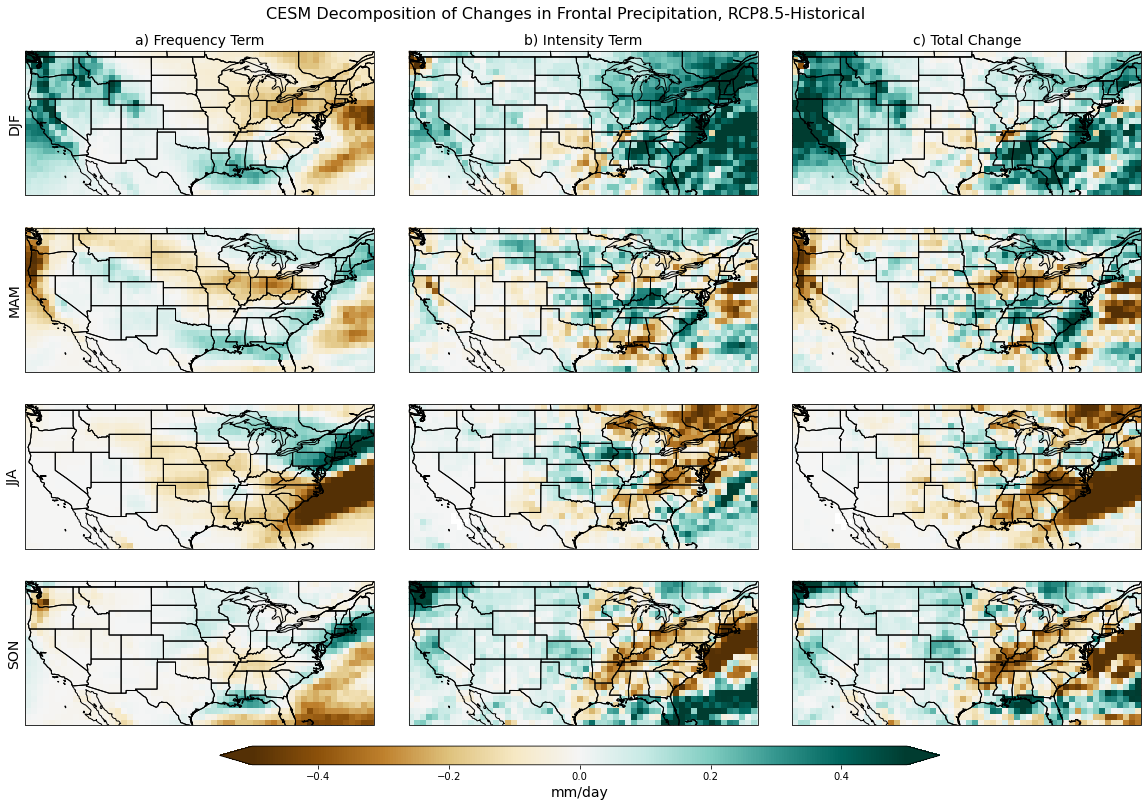

In [42]:
# removing covariance term (small)
seastrings = ('DJF', 'MAM', 'JJA', 'SON')
nsea = len(seastrings)
fig, axs = plt.subplots(nsea, 3, figsize=(20,13), subplot_kw={'projection': ccrs.PlateCarree()})

cmap = plt.cm.get_cmap('BrBG')

# Constant scaling
vmin=-0.5
vmax=0.5

# Frequency term
for i, season in enumerate(seastrings):
    if i==0:
        axs[i,0].set_title('a) Frequency Term', fontsize=14)
    field, lon = add_cyclic_point(freq_term.sel(season=season), coord=freq_term.lon)
    lat = freq_term.lat
    cf = axs[i,0].pcolor(lon, lat, field, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
    axs[i,0].coastlines(zorder=1)
    axs[i,0].add_feature(cfeature.BORDERS, zorder=2)
    axs[i,0].add_feature(cfeature.STATES, zorder=3)
    #axs[i,0].add_feature(cfeature.OCEAN, zorder=4, facecolor='gainsboro', edgecolor='none')
    axs[i,0].set_ylabel(season, fontsize=14)
    axs[i,0].set_yticks([])

# Intensity term
for i, season in enumerate(seastrings):
    if i==0:
        axs[i,1].set_title('b) Intensity Term', fontsize=14)
    field, lon = add_cyclic_point(int_term.sel(season=season), coord=int_term.lon)
    lat = int_term.lat
    cf = axs[i,1].pcolor(lon, lat, field, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
    axs[i,1].coastlines(zorder=1)
    axs[i,1].add_feature(cfeature.BORDERS, zorder=2)
    axs[i,1].add_feature(cfeature.STATES, zorder=3)
    #axs[i,1].add_feature(cfeature.OCEAN, zorder=4, facecolor='gainsboro', edgecolor='none')

# Total change
for i, season in enumerate(seastrings):
    if i==0:
        axs[i,2].set_title('c) Total Change', fontsize=14)
    field, lon = add_cyclic_point(delta_P.sel(season=season), coord=delta_P.lon)
    lat = delta_P.lat
    cf = axs[i,2].pcolor(lon, lat, field, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
    axs[i,2].coastlines(zorder=1)
    axs[i,2].add_feature(cfeature.BORDERS, zorder=2)
    axs[i,2].add_feature(cfeature.STATES, zorder=3)
    #axs[i,2].add_feature(cfeature.OCEAN, zorder=4, facecolor='gainsboro', edgecolor='none')

# common colorbar
cb_ax = fig.add_axes([0.26, 0.1, 0.5, 0.02])
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cb = mpl.colorbar.ColorbarBase(cb_ax, cmap, norm=norm, orientation='horizontal', extend='both')
cb.ax.set_xlabel('mm/day', fontsize=14)
    
plt.subplots_adjust(wspace=0.1, hspace=0)
fig.suptitle('CESM Decomposition of Changes in Frontal Precipitation, RCP8.5-Historical', fontsize=16, y=0.91);

#plt.savefig('../figures/toSCP/CESM_frontalPRECT_freq_int_total.png', bbox_inches='tight', dpi=300)

### Compare the total changes (calculated from the previous decomposition) with the change in mean frontal precip

In [68]:
PRECT_front_mean_byseason = PRECT.sel(lat=slice(26,50), lon=slice(-125,-68)).where(fronts.notnull()).groupby("time.season").mean(dim='time')
PRECT_front_mean_byseason

<xarray.DataArray 'PRECT' (season: 4, lat: 25, lon: 58)>
dask.array<stack, shape=(4, 25, 58), dtype=float64, chunksize=(1, 10, 20), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 26.0 27.0 28.0 29.0 30.0 ... 46.0 47.0 48.0 49.0 50.0
  * lon      (lon) float64 -125.0 -124.0 -123.0 -122.0 ... -70.0 -69.0 -68.0
  * season   (season) object 'DJF' 'JJA' 'MAM' 'SON'

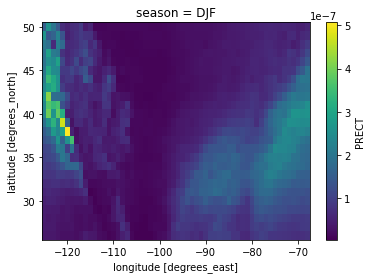

In [69]:
PRECT_front_mean_byseason.sel(season='DJF').plot()

In [70]:
PRECT_front_mean_rcp_byseason = PRECT_rcp.sel(lat=slice(26,50), lon=slice(-125,-68)).where(fronts_rcp.notnull()).groupby("time.season").mean(dim='time')

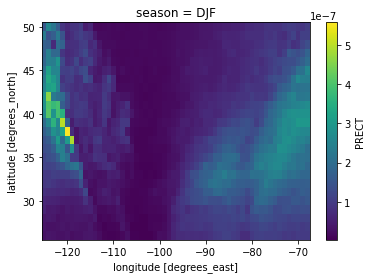

In [71]:
PRECT_front_mean_rcp_byseason.sel(season='DJF').plot()

In [72]:
PRECT_front_mean_diff_byseason = (PRECT_front_mean_rcp_byseason - PRECT_front_mean_byseason)*Punits # convert to mm/day

In [73]:
PRECT_front_mean_diff_byseason = PRECT_front_mean_diff_byseason.persist()

In [74]:
print(PRECT_front_mean_diff_byseason.max().values, PRECT_front_mean_diff_byseason.min().values)

11.496106832485937 -8.496687985315514


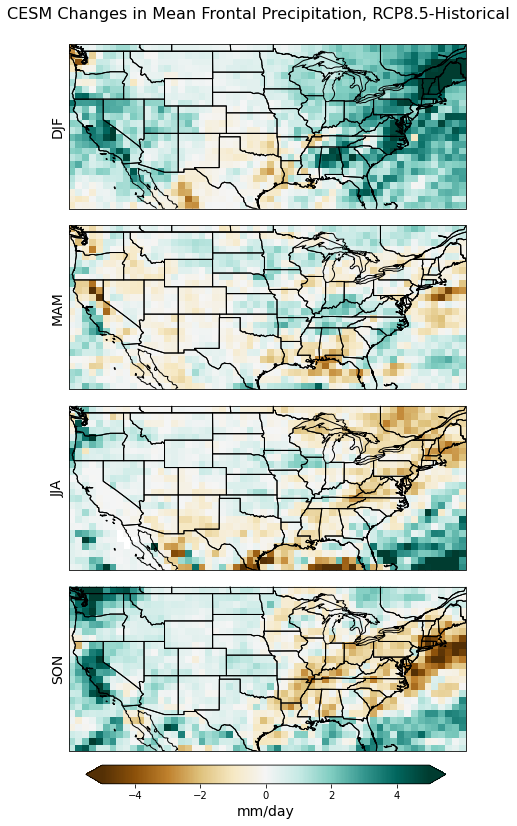

In [79]:
# this is just a repeat of the mean frontal precip intensity plot from above
# but good that the spatial pattern roughly matches the total plot from the decomposition
seastrings = ('DJF', 'MAM', 'JJA', 'SON')
nsea = len(seastrings)
fig, axs = plt.subplots(nsea, 1, figsize=(10,13), subplot_kw={'projection': ccrs.PlateCarree()})

cmap = plt.cm.get_cmap('BrBG')

vmin=-5
vmax=5

for i, season in enumerate(seastrings):
    field, lon = add_cyclic_point(PRECT_front_mean_diff_byseason.sel(season=season), coord=PRECT_front_mean_diff_byseason.lon)
    lat = PRECT_front_mean_diff_byseason.lat
    cf = axs[i].pcolor(lon, lat, field, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
    axs[i].coastlines(zorder=1)
    axs[i].add_feature(cfeature.BORDERS, zorder=2)
    axs[i].add_feature(cfeature.STATES, zorder=3)
    #axs[i].add_feature(cfeature.OCEAN, zorder=4, facecolor='gainsboro', edgecolor='none')
    axs[i].set_ylabel(season, fontsize=14)
    axs[i].set_yticks([])
    
cb_ax = fig.add_axes([0.26, 0.09, 0.5, 0.02])
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cb = mpl.colorbar.ColorbarBase(cb_ax, cmap=cmap, norm=norm, orientation='horizontal', extend='both')
cb.ax.set_xlabel('mm/day', fontsize=14)  

fig.suptitle('CESM Changes in Mean Frontal Precipitation, RCP8.5-Historical', fontsize=16, y=0.92)
plt.subplots_adjust(wspace=0, hspace=0.1)

#plt.savefig('../figures/toSCP/CESM_mean_frontalPRECT_diff.png', bbox_inches='tight', dpi=300)

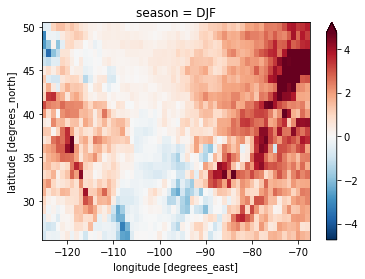

In [81]:
# difference from above
(PRECT_front_mean_diff_byseason - delta_P).sel(season='DJF').plot(robust=True)

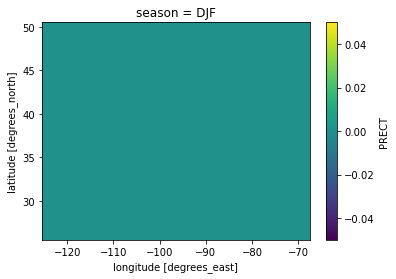

In [83]:
# sanity check difference with previously calculated intensity (they are the same)
(PRECT_front_mean_diff_byseason - (PRECT_front_int_CONUS_diff)*Punits).sel(season='DJF').plot()

### By front type

In [97]:
freq_term_type, int_term_type, cov_term_type, delta_P_type = calc_freq_int(front_freq_type_CONUS, front_freq_type_CONUS_diff, PRECT_front_int_type_CONUS, PRECT_front_int_type_CONUS_diff)

In [98]:
freq_term_type

<xarray.DataArray (front_type: 4, season: 4, lat: 25, lon: 58)>
dask.array<mul, shape=(4, 4, 25, 58), dtype=float64, chunksize=(1, 1, 10, 20), chunktype=numpy.ndarray>
Coordinates:
  * front_type  (front_type) object 'cold' 'warm' 'stationary' 'occluded'
  * lon         (lon) float64 -125.0 -124.0 -123.0 -122.0 ... -70.0 -69.0 -68.0
  * lat         (lat) float64 26.0 27.0 28.0 29.0 30.0 ... 47.0 48.0 49.0 50.0
  * season      (season) object 'DJF' 'JJA' 'MAM' 'SON'

In [113]:
print(freq_term_type.max(dim=('lat','lon','season')).values, freq_term_type.min(dim=('lat','lon','season')).values)

[0.76323592 0.48501643 0.7852371  0.26202338] [-0.64488382 -0.55253759 -0.99665439 -0.2175498 ]


In [114]:
print(int_term_type.max(dim=('lat','lon','season')).values, int_term_type.min(dim=('lat','lon','season')).values)

[0.65311391 0.68256178 1.21047705 0.32397898] [-0.44309678 -0.26635834 -0.68246172 -0.26134041]


In [115]:
print(cov_term_type.max(dim=('lat','lon','season')).values, cov_term_type.min(dim=('lat','lon','season')).values)

[0.1108299  0.15287116 0.09198172 0.09992429] [-0.13017655 -0.35861285 -0.51549305 -0.26062585]


In [116]:
print(delta_P_type.max(dim=('lat','lon','season')).values, delta_P_type.min(dim=('lat','lon','season')).values)

[0.65704079 0.5161422  0.64211352 0.25886652] [-0.72769888 -0.63668199 -0.91446735 -0.37248075]


/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1887: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)
/glade/scratch/kdagon/ipykernel_120635/1504625114.py:62: MatplotlibDeprecationWarning: Passing the cmap parameter of __init__() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.
  cb = mpl.colorbar.ColorbarBase(cb_ax, cmap, norm=norm, orientation='horizontal', extend='both')


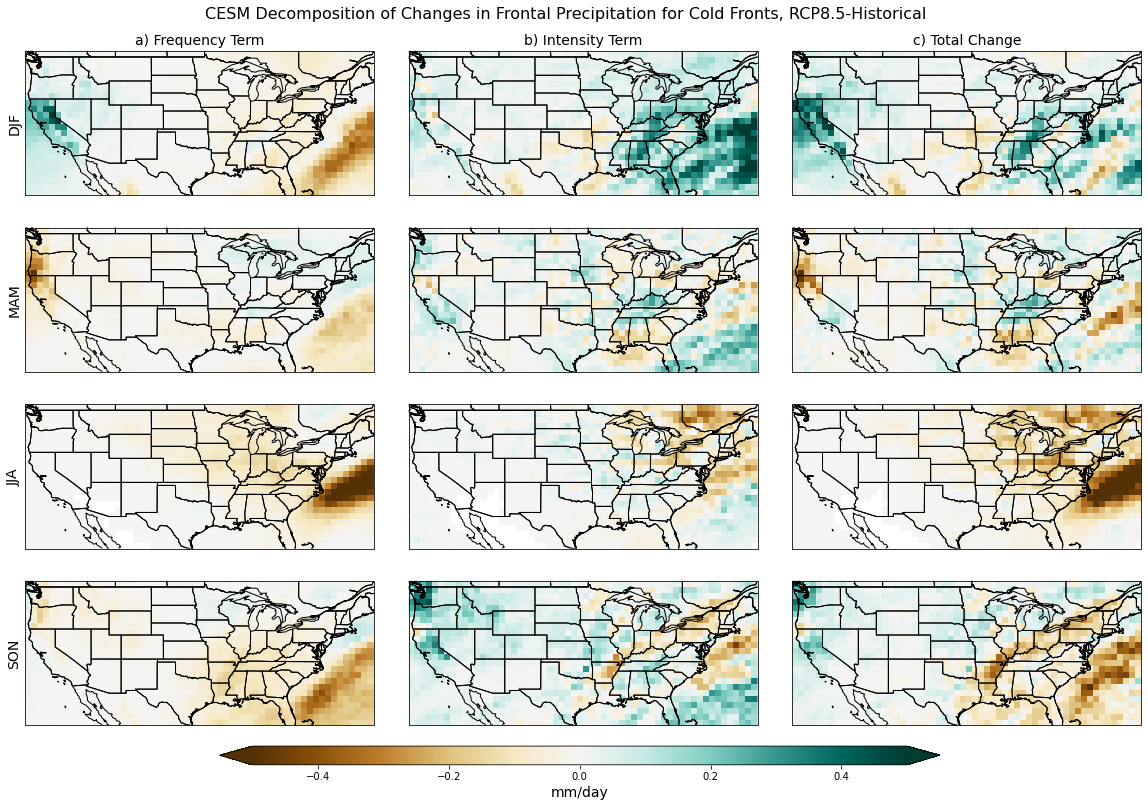

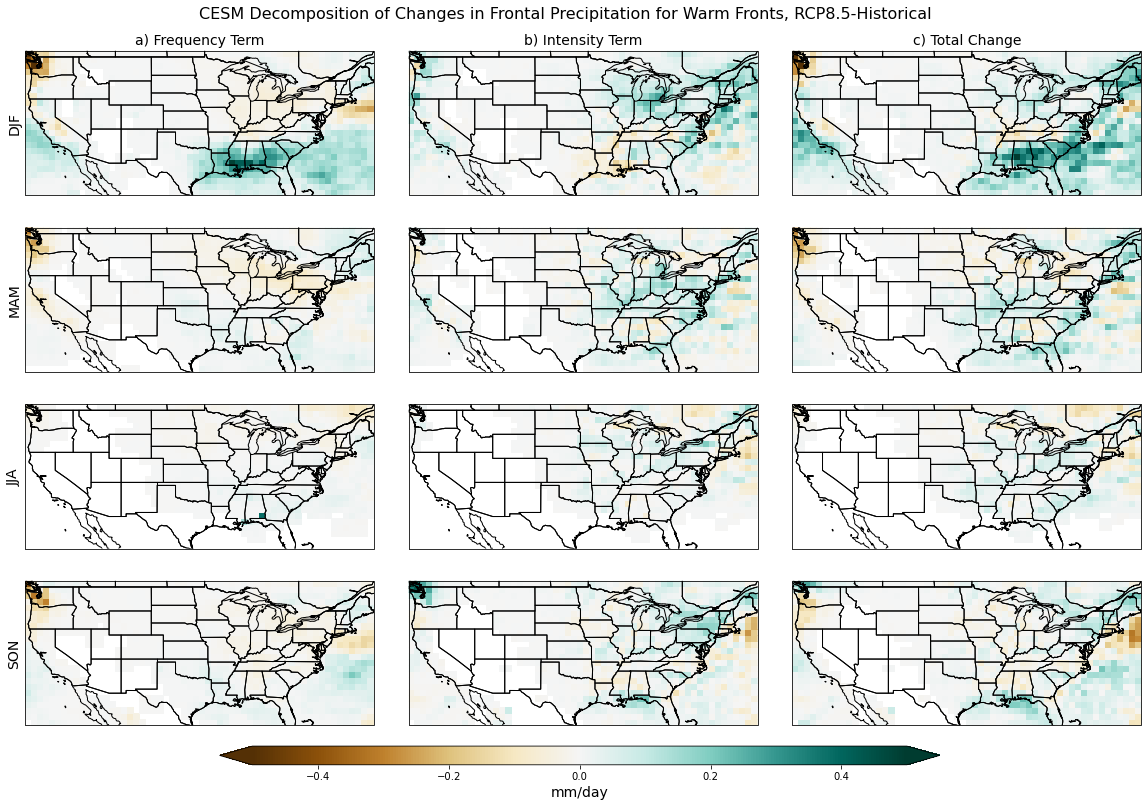

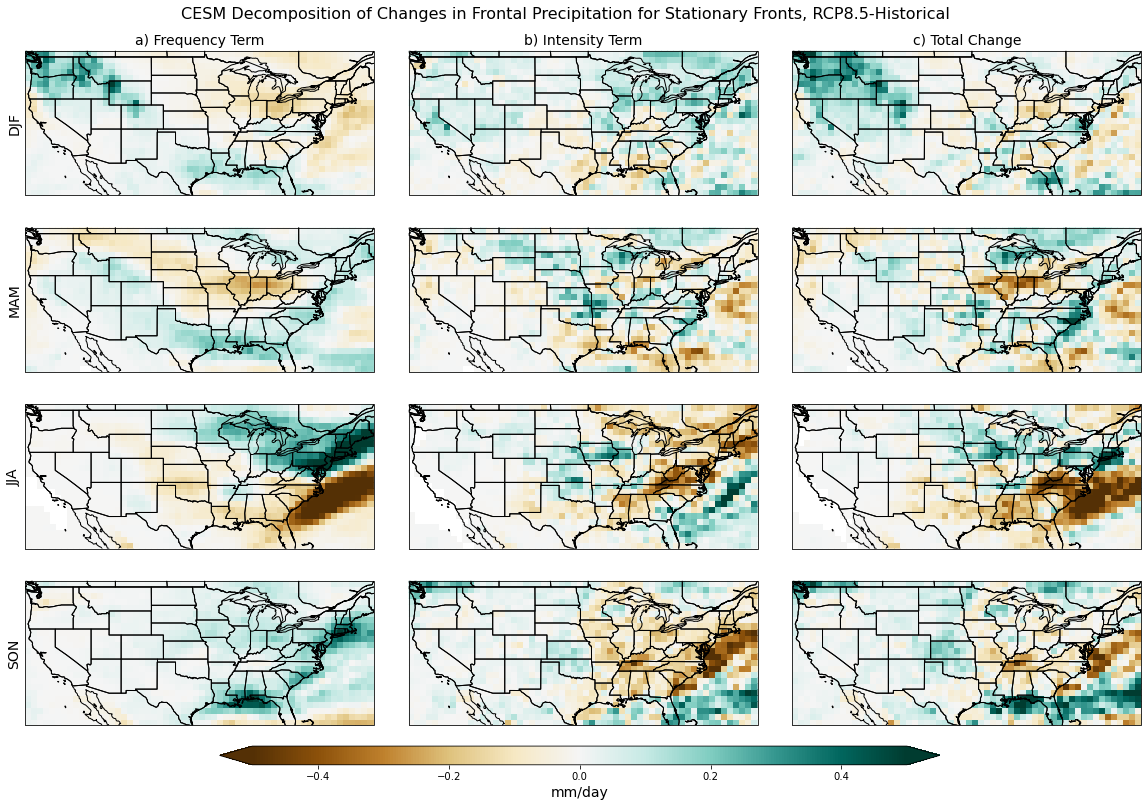

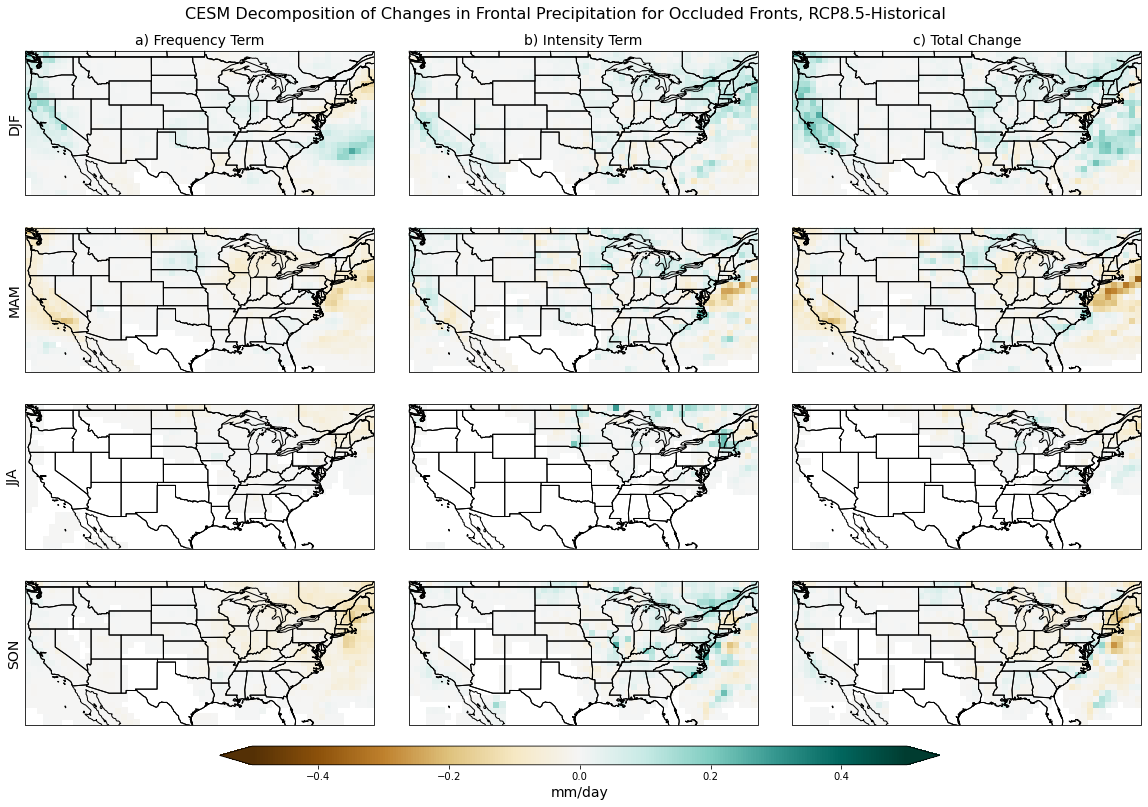

In [117]:
# loop over front type
frstrings = ('Cold', 'Warm', 'Stationary', 'Occluded') # for labels
ftypes = ('cold', 'warm', 'stationary', 'occluded') # lowercase for indexing
nfr = len(frstrings)

#vmaxes = [3,1.4,4,1]
#ncols = [6,7,8,10]
#vdiffs = [1,0.5,1,0.25]

seastrings = ('DJF', 'MAM', 'JJA', 'SON')
nsea = len(seastrings)
for f in range(nfr):
    fig, axs = plt.subplots(nsea, 3, figsize=(20,13), subplot_kw={'projection': ccrs.PlateCarree()})

    cmap = plt.cm.get_cmap('BrBG')

    # Constant scaling
    vmin=-0.5
    vmax=0.5

    # Frequency term
    for i, season in enumerate(seastrings):
        if i==0:
            axs[i,0].set_title('a) Frequency Term', fontsize=14)
        field, lon = add_cyclic_point(freq_term_type.sel(season=season, front_type=ftypes[f]), coord=freq_term_type.lon)
        lat = freq_term_type.lat
        cf = axs[i,0].pcolor(lon, lat, field, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
        axs[i,0].coastlines(zorder=1)
        axs[i,0].add_feature(cfeature.BORDERS, zorder=2)
        axs[i,0].add_feature(cfeature.STATES, zorder=3)
        #axs[i,0].add_feature(cfeature.OCEAN, zorder=4, facecolor='gainsboro', edgecolor='none')
        axs[i,0].set_ylabel(season, fontsize=14)
        axs[i,0].set_yticks([])

    # Intensity term
    for i, season in enumerate(seastrings):
        if i==0:
            axs[i,1].set_title('b) Intensity Term', fontsize=14)
        field, lon = add_cyclic_point(int_term_type.sel(season=season, front_type=ftypes[f]), coord=int_term_type.lon)
        lat = int_term_type.lat
        cf = axs[i,1].pcolor(lon, lat, field, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
        axs[i,1].coastlines(zorder=1)
        axs[i,1].add_feature(cfeature.BORDERS, zorder=2)
        axs[i,1].add_feature(cfeature.STATES, zorder=3)
        #axs[i,1].add_feature(cfeature.OCEAN, zorder=4, facecolor='gainsboro', edgecolor='none')

    # Total change
    for i, season in enumerate(seastrings):
        if i==0:
            axs[i,2].set_title('c) Total Change', fontsize=14)
        field, lon = add_cyclic_point(delta_P_type.sel(season=season, front_type=ftypes[f]), coord=delta_P_type.lon)
        lat = delta_P_type.lat
        cf = axs[i,2].pcolor(lon, lat, field, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
        axs[i,2].coastlines(zorder=1)
        axs[i,2].add_feature(cfeature.BORDERS, zorder=2)
        axs[i,2].add_feature(cfeature.STATES, zorder=3)
        #axs[i,2].add_feature(cfeature.OCEAN, zorder=4, facecolor='gainsboro', edgecolor='none')

    # common colorbar
    cb_ax = fig.add_axes([0.26, 0.1, 0.5, 0.02])
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    cb = mpl.colorbar.ColorbarBase(cb_ax, cmap, norm=norm, orientation='horizontal', extend='both')
    cb.ax.set_xlabel('mm/day', fontsize=14)
    
    plt.subplots_adjust(wspace=0.1, hspace=0)
    fig.suptitle('CESM Decomposition of Changes in Frontal Precipitation for '+frstrings[f]+' Fronts, RCP8.5-Historical', fontsize=16, y=0.91);

    plt.savefig('../figures/toSCP/CESM_frontalPRECT_freq_int_total_'+ftypes[f]+'_fronts.png', bbox_inches='tight', dpi=300)

### Spatial means for bar charts

In [101]:
def spatial_mean(array):
    
    weights = np.cos(np.deg2rad(array.lat))
    weights.name = "weights"
    array_weighted = array.weighted(weights)
    array_weighted_mean = array_weighted.mean(("lon","lat"))
    
    return(array_weighted_mean)

In [102]:
freq_term_type_mean = spatial_mean(freq_term_type)
int_term_type_mean = spatial_mean(int_term_type)
delta_P_type_mean = spatial_mean(delta_P_type)

In [103]:
freq_term_type_mean

<xarray.DataArray (front_type: 4, season: 4)>
dask.array<truediv, shape=(4, 4), dtype=float64, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
  * front_type  (front_type) object 'cold' 'warm' 'stationary' 'occluded'
  * season      (season) object 'DJF' 'JJA' 'MAM' 'SON'

In [104]:
freq_term_type_mean.sel(season='DJF').values

array([-0.01824399,  0.02836288,  0.00869364,  0.009229  ])

In [109]:
freq_term_type_mean.sel(front_type='cold').values

array([-0.01824399, -0.05034772, -0.02314702, -0.04838974])

In [106]:
np.sign(freq_term_type_mean).values

array([[-1., -1., -1., -1.],
       [ 1., -1., -1., -1.],
       [ 1., -1.,  1.,  1.],
       [ 1., -1., -1., -1.]])

In [105]:
int_term_type_mean.sel(season='DJF').values

array([0.07070487, 0.0246697 , 0.03511656, 0.01328952])

In [117]:
int_term_type_mean.sel(front_type='cold').values

array([ 0.07070487, -0.01663649,  0.01612377,  0.03597382])

In [120]:
xlabels = ['DJF', 'MAM', 'JJA', 'SON']
for j,n in enumerate(freq_term_type_mean.sel(front_type='cold')):
    print(xlabels[j])
    print('frequency sign is')
    print(np.sign(freq_term_type_mean.sel(front_type='cold', season=xlabels[j])).values)
    print('intensity sign is')
    print(np.sign(int_term_type_mean.sel(front_type='cold', season=xlabels[j])).values)

DJF
frequency sign is
-1.0
intensity sign is
1.0
MAM
frequency sign is
-1.0
intensity sign is
1.0
JJA
frequency sign is
-1.0
intensity sign is
-1.0
SON
frequency sign is
-1.0
intensity sign is
1.0


In [122]:
i = 0

seastrings = ['DJF', 'MAM', 'JJA', 'SON']
nseason = len(seastrings)
x = np.arange(nseason)

flabels = ['Cold', 'Warm', 'Stationary', 'Occluded']
nbars = len(flabels)
w = 0.75/nbars

position = x + (w*(1-nbars)/2) + i*w
print(position)

[-0.28125  0.71875  1.71875  2.71875]


In [108]:
import matplotlib.patches as mpatches

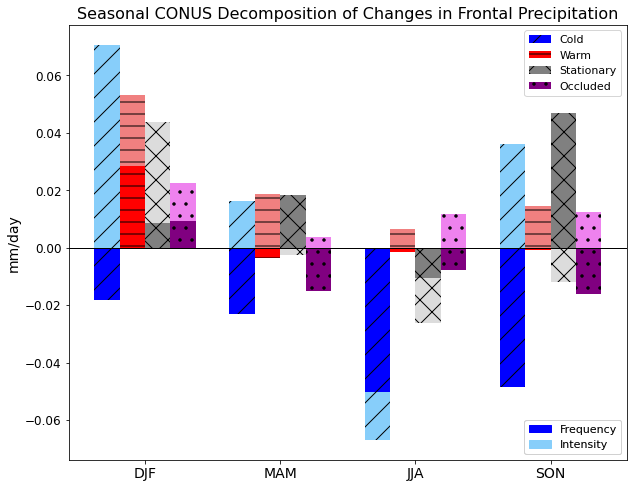

In [126]:
fig, ax = plt.subplots(figsize=(10,8))

seastrings = ['DJF', 'MAM', 'JJA', 'SON']
nseason = len(seastrings)
x = np.arange(nseason)  # the label locations

flabels = ['Cold', 'Warm', 'Stationary', 'Occluded']
ftypes = ['cold', 'warm', 'stationary', 'occluded']
# number of bars per xlabel
nbars = len(flabels)
# width
w = 0.75/nbars

fcolors=['blue','red','grey','purple']
icolors=['lightskyblue','lightcoral','gainsboro','violet']
hatches=['/','-','x','.']

bottom = np.zeros((nbars,nseason))

# loop over fronts
for i,f in enumerate(ftypes):

    position = x + (w*(1-nbars)/2) + i*w
    
    # loop over seasons
    for j,s in enumerate(seastrings):
        
        # legend label for first season only
        if j==0:
            ax.bar(position[j], freq_term_type_mean.sel(front_type=f, season=s), width=w, label=flabels[i], color=fcolors[i], hatch=hatches[i])
        else:
            ax.bar(position[j], freq_term_type_mean.sel(front_type=f, season=s), width=w, color=fcolors[i], hatch=hatches[i])
            
        # define bottom for stacked bar chart
        if np.sign(freq_term_type_mean.sel(front_type=f, season=s)) == np.sign(int_term_type_mean.sel(front_type=f,season=s)):
            bottom[i,j] = freq_term_type_mean.sel(front_type=f, season=s)
        else:
            bottom[i,j] = 0
        ax.bar(position[j], int_term_type_mean.sel(front_type=f, season=s), width=w, color=icolors[i], hatch=hatches[i], bottom=bottom[i,j])



ax.set_title('Seasonal CONUS Decomposition of Changes in Frontal Precipitation', fontsize=16)
ax.set_ylabel('mm/day', fontsize=14)
ax.tick_params(axis='y', labelsize=12)
ax.set_xticks(x)
ax.set_xticklabels(seastrings, fontsize=14)
ax.axhline(y=0, color='black', lw=1)
legend1 = ax.legend(bbox_to_anchor=(1, 1), fontsize=11)
plt.gca().add_artist(legend1)

# first legend 
#cold_patch = mpatches.Patch(color='blue', hatch='/', label='Cold')
#warm_patch = mpatches.Patch(color='red', hatch='-', label='Warm')
#stat_patch = mpatches.Patch(color='grey', hatch='x', label='Stationary')
#occ_patch = mpatches.Patch(color='purple', hatch='.', label='Occluded')
#handles=[cold_patch,warm_patch,stat_patch,occ_patch]
#legend1 = plt.legend(handles, loc=1, fontsize=11)
#plt.gca().add_artist(legend1)

# second legend
freq_patch = mpatches.Patch(color='blue', label='Frequency')
int_patch = mpatches.Patch(color='lightskyblue', label='Intensity')
legend2 = plt.legend(handles=[freq_patch, int_patch], loc=4, fontsize=11)

# add second legend
plt.gca().add_artist(legend2)

#plt.savefig('../figures/toSCP/CESM_CONUS_mean_freq_int_fronttype.png', bbox_inches='tight', dpi=300)

## Calculate mean changes in precipitation

In [85]:
# mean change in precipitation, mm/day
# by simple averaging over all 3hrly time points
mean_PRECT_CONUS = ((PRECT_rcp.mean(dim='time') - PRECT.mean(dim='time'))*Punits).sel(lat=slice(26,50), lon=slice(-125,-68))

In [86]:
# mean change in precip by season, mm/day
mean_PRECT_CONUS_byseason = ((PRECT_rcp.groupby('time.season').mean(dim='time') - PRECT.groupby('time.season').mean(dim='time'))*Punits).sel(lat=slice(26,50), lon=slice(-125,-68))

In [87]:
print(mean_PRECT_CONUS_byseason.max().values, mean_PRECT_CONUS_byseason.min().values)

4.306107448834873 -1.9278725036314566


/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1887: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)


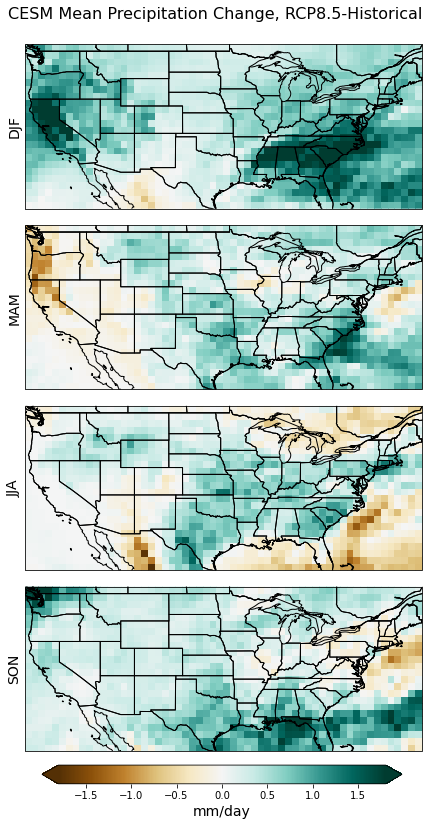

In [91]:
# comparing PRECT seasonal changes computed without fronts
seastrings = ('DJF', 'MAM', 'JJA', 'SON')
nsea = len(seastrings)
fig, axs = plt.subplots(nsea, 1, figsize=(10,13), subplot_kw={'projection': ccrs.PlateCarree()})

cmap = plt.cm.get_cmap('BrBG')

vmin=-1.8
vmax=1.8

for i, season in enumerate(seastrings):
    #if i==0:
        #axs[i,0].set_title('a) Frequency Term', fontsize=14)
    field, lon = add_cyclic_point(mean_PRECT_CONUS_byseason.sel(season=season), coord=mean_PRECT_CONUS_byseason.lon)
    lat = mean_PRECT_CONUS_byseason.lat
    cf = axs[i].pcolor(lon, lat, field, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
    axs[i].coastlines(zorder=1)
    axs[i].add_feature(cfeature.BORDERS, zorder=2)
    axs[i].add_feature(cfeature.STATES, zorder=3)
    #axs[i].add_feature(cfeature.OCEAN, zorder=4, facecolor='gainsboro', edgecolor='none')
    axs[i].set_ylabel(season, fontsize=14)
    axs[i].set_yticks([])
    
cb_ax = fig.add_axes([0.26, 0.09, 0.5, 0.02])
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cb = mpl.colorbar.ColorbarBase(cb_ax, cmap=cmap, norm=norm, orientation='horizontal', extend='both')
cb.ax.set_xlabel('mm/day', fontsize=14)  

fig.suptitle('CESM Mean Precipitation Change, RCP8.5-Historical', fontsize=16, y=0.92)
plt.subplots_adjust(wspace=0, hspace=0.1)

#plt.savefig('../figures/toSCP/CESM_season_mean_PRECT_diff.png', bbox_inches='tight', dpi=300)

## Contribution of fronts to mean change in precipitation

In [93]:
# not sure what makes the most sense to put in the denominator here
Cnt_fronts = delta_P/abs(mean_PRECT_CONUS_byseason) # using delta P from breakdown for numerator
#Cnt_fronts = PRECT_front_mean_diff_byseason/abs(mean_PRECT_CONUS_byseason) # using changes in mean frontal precipitation for numerator

In [94]:
print(Cnt_fronts.max().values, Cnt_fronts.min().values)

86.13119238824105 -476.2151368292512


/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1887: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  result = matplotlib.axes.Axes.pcolor(self, *args, **kwargs)


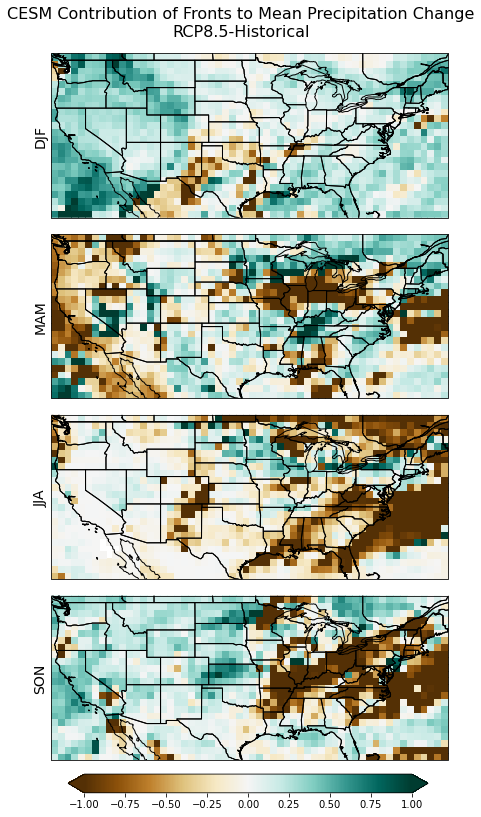

In [95]:
seastrings = ('DJF', 'MAM', 'JJA', 'SON')
nsea = len(seastrings)
fig, axs = plt.subplots(nsea, 1, figsize=(10,13), subplot_kw={'projection': ccrs.PlateCarree()})

cmap = plt.cm.get_cmap('BrBG')

vmin=-1
vmax=1

for i, season in enumerate(seastrings):
    #if i==0:
        #axs[i,0].set_title('a) Frequency Term', fontsize=14)
    field, lon = add_cyclic_point(Cnt_fronts.sel(season=season), coord=Cnt_fronts.lon)
    lat = Cnt_fronts.lat
    cf = axs[i].pcolor(lon, lat, field, cmap=cmap, vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
    axs[i].coastlines(zorder=1)
    axs[i].add_feature(cfeature.BORDERS, zorder=2)
    axs[i].add_feature(cfeature.STATES, zorder=3)
    #axs[i].add_feature(cfeature.OCEAN, zorder=4, facecolor='gainsboro', edgecolor='none')
    axs[i].set_ylabel(season, fontsize=14)
    axs[i].set_yticks([])
    
cb_ax = fig.add_axes([0.26, 0.09, 0.5, 0.02])
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
cb = mpl.colorbar.ColorbarBase(cb_ax, cmap=cmap, norm=norm, orientation='horizontal', extend='both')
#cb.ax.set_xlabel('', fontsize=14)  

fig.suptitle('CESM Contribution of Fronts to Mean Precipitation Change\nRCP8.5-Historical', fontsize=16, y=0.93)
plt.subplots_adjust(wspace=0, hspace=0.1)

#plt.savefig('../figures/toSCP/CESM_Cnt_fronts.png', bbox_inches='tight', dpi=300)

## Sensitivity of low precip days

In [198]:
PRECT

<xarray.DataArray 'PRECT' (time: 43800, lat: 68, lon: 141)>
dask.array<where, shape=(43800, 68, 141), dtype=float64, chunksize=(600, 10, 20), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2000-01-01 03:00:00 ... 2015-01-01 00:00:00
  * lon      (lon) float64 -171.0 -170.0 -169.0 -168.0 ... -33.0 -32.0 -31.0
  * lat      (lat) float64 10.0 11.0 12.0 13.0 14.0 ... 73.0 74.0 75.0 76.0 77.0
Attributes:
    regrid_method:  bilinear

In [195]:
PRECT_day_sum = PRECT.resample(time='D').sum(dim='time')

In [196]:
PRECT_day_sum

<xarray.DataArray 'PRECT' (time: 5476, lat: 68, lon: 141)>
dask.array<stack, shape=(5476, 68, 141), dtype=float64, chunksize=(1, 10, 20), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2000-01-01 00:00:00 ... 2015-01-01 00:00:00
  * lon      (lon) float64 -171.0 -170.0 -169.0 -168.0 ... -33.0 -32.0 -31.0
  * lat      (lat) float64 10.0 11.0 12.0 13.0 14.0 ... 73.0 74.0 75.0 76.0 77.0

In [ ]:
PRECT_day_sum_rcp = PRECT_rcp.resample(time='D').sum(dim='time)

### Save out daily total precip file to prevent Dask memory issues
This is very slow...use `cdo daysum` instead in the command line

In [197]:
PRECT_day_sum.to_netcdf(postprocessing_filepath+'PRECT_day_sum_hist_rcp26.nc', mode='w', format='NETCDF4')

In [ ]:
PRECT_day_sum_rcp.to_netcdf(postprocessing_filepath+'PRECT_day_sum_rcp85.nc', mode='w', format='NETCDF4')